# Coreference Resolution con XLM-RoBERTa
## Modelo para identificar clusters de coreferencia

## 1. Instalación de Dependencias

In [1]:
# Instalación de paquetes necesarios
# !pip install -q transformers torch datasets numpy scikit-learn spacy matplotlib tqdm wandb
# !python -m spacy download es_core_news_sm
# !python -m spacy download en_core_web_sm

## 2. Imports y Configuración

In [2]:
## 2. Imports y Configuración - VERSIÓN GPU

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import json
import random
import os
from typing import List, Dict, Tuple, Optional
from dataclasses import dataclass
from collections import defaultdict

# Transformers y NLP
from transformers import (
    XLMRobertaModel,
    XLMRobertaTokenizer,
    XLMRobertaConfig,
    get_linear_schedule_with_warmup
)

# Datos y visualización
from torch.utils.data import Dataset, DataLoader, TensorDataset
from sklearn.metrics import precision_recall_fscore_support
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import spacy

# ============================================================================
# CONFIGURACIÓN AVANZADA DE GPU
# ============================================================================

def setup_gpu():
    """Configuración avanzada para GPU"""
    # Verificar CUDA
    if not torch.cuda.is_available():
        print("❌ CUDA no disponible. Usando CPU.")
        return torch.device("cpu")

    print("✅ CUDA disponible")
    print(f"🎯 PyTorch versión: {torch.__version__}")
    print(f"🎯 CUDA versión: {torch.version.cuda}")

    # Información de GPU
    device_count = torch.cuda.device_count()
    print(f"🎯 Número de GPUs: {device_count}")

    for i in range(device_count):
        gpu_name = torch.cuda.get_device_name(i)
        gpu_memory = torch.cuda.get_device_properties(i).total_memory / 1e9
        print(f"  GPU {i}: {gpu_name} ({gpu_memory:.1f} GB)")

    # Seleccionar dispositivo
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

    # Configuración de GPU
    if torch.cuda.is_available():
        # Habilitar cudnn para mejor rendimiento
        torch.backends.cudnn.enabled = True
        torch.backends.cudnn.benchmark = True

        # Configurar tensor cores si está disponible
        if hasattr(torch.cuda, 'amp') and hasattr(torch.cuda.amp, 'autocast'):
            print("✅ Tensor Cores (AMP) disponible")

        # Probar operación simple en GPU
        try:
            test_tensor = torch.randn(100, 100).cuda()
            _ = test_tensor @ test_tensor.t()
            print("✅ GPU funciona correctamente")
            del test_tensor
            torch.cuda.empty_cache()
        except Exception as e:
            print(f"❌ Error en GPU: {e}")
            device = torch.device("cpu")

    print(f"🔧 Dispositivo configurado: {device}")
    return device

# Configurar dispositivo
device = setup_gpu()

# Configuración de reproducción
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)

# Función para limpiar memoria GPU
def clear_gpu_memory():
    """Limpia la memoria de la GPU"""
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
        print("🧹 Memoria GPU limpiada")

✅ CUDA disponible
🎯 PyTorch versión: 2.1.0+cu121
🎯 CUDA versión: 12.1
🎯 Número de GPUs: 1
  GPU 0: NVIDIA GeForce RTX 4060 Laptop GPU (8.6 GB)
✅ Tensor Cores (AMP) disponible
✅ GPU funciona correctamente
🔧 Dispositivo configurado: cuda:0


## 3. Definición del Modelo de Coreferencia

In [3]:
class SpanRepresentation(nn.Module):
    """Módulo para representar spans de texto - VERSIÓN CON PADDING"""

    def __init__(self, hidden_size: int, max_span_width: int = 10):
        super().__init__()
        self.hidden_size = hidden_size
        self.max_span_width = max_span_width

        # Capas para embeddings de inicio y fin
        self.start_mlp = nn.Linear(hidden_size, hidden_size)
        self.end_mlp = nn.Linear(hidden_size, hidden_size)

        # Embeddings para el ancho del span
        self.span_width_embeddings = nn.Embedding(max_span_width, hidden_size)

        # Atención para tokens internos del span
        self.span_attention = nn.Linear(hidden_size, 1)

        # Capa de normalización
        self.layer_norm = nn.LayerNorm(hidden_size)

    def forward(self, sequence_output: torch.Tensor,
                span_indices: List[List[Tuple[int, int]]]) -> Tuple[torch.Tensor, torch.Tensor]:
        """
        Args:
            sequence_output: [batch_size, seq_len, hidden_size]
            span_indices: Lista de listas de (start_idx, end_idx) por batch
        Returns:
            span_embeddings: [batch_size, max_num_spans_in_batch, hidden_size]
            span_mask: [batch_size, max_num_spans_in_batch] (1 para spans válidos, 0 para padding)
        """
        batch_size, seq_len, hidden_size = sequence_output.shape

        # Encontrar el máximo número de spans en este batch
        max_spans_in_batch = max(len(spans) for spans in span_indices)

        # Inicializar tensores para embeddings y máscara
        span_embeddings = torch.zeros(batch_size, max_spans_in_batch, hidden_size, device=device)
        span_mask = torch.zeros(batch_size, max_spans_in_batch, device=device)

        for b in range(batch_size):
            batch_spans = span_indices[b]
            num_spans = len(batch_spans)

            # Marcar spans válidos
            span_mask[b, :num_spans] = 1

            for span_idx, (start_idx, end_idx) in enumerate(batch_spans):
                # Asegurar que el span sea válido
                if start_idx >= seq_len or end_idx >= seq_len or start_idx > end_idx:
                    # Span inválido, usar vector cero (ya está inicializado como cero)
                    continue

                # 1. Embeddings de inicio y fin
                start_emb = sequence_output[b, start_idx, :]
                end_emb = sequence_output[b, end_idx, :]

                start_proj = self.start_mlp(start_emb)
                end_proj = self.end_mlp(end_emb)

                # 2. Embedding del ancho del span
                span_width = min(end_idx - start_idx, self.max_span_width - 1)
                width_idx = torch.tensor(span_width, device=device)
                width_emb = self.span_width_embeddings(width_idx)

                # 3. Atención sobre los tokens internos
                if end_idx > start_idx:
                    span_tokens = sequence_output[b, start_idx:end_idx+1, :]
                    attention_weights = F.softmax(
                        self.span_attention(span_tokens), dim=0
                    )
                    attended_rep = torch.sum(attention_weights * span_tokens, dim=0)
                else:
                    attended_rep = sequence_output[b, start_idx, :]

                # 4. Combinar representaciones
                span_rep = start_proj + end_proj + width_emb + attended_rep
                span_rep = self.layer_norm(span_rep)

                span_embeddings[b, span_idx, :] = span_rep

        return span_embeddings, span_mask

class CoreferenceScorer(nn.Module):
    """Calcula scores de coreferencia entre pares de spans - VERSIÓN CON MÁSCARA"""

    def __init__(self, hidden_size: int, feature_size: int = 128):
        super().__init__()

        # Features para distancia y otros metadatos
        self.distance_embeddings = nn.Embedding(50, 20)  # Distancias hasta 50 tokens
        self.same_sentence_emb = nn.Embedding(2, 10)     # ¿Misma oración?

        # Capas para combinar representaciones
        self.span_pair_mlp = nn.Sequential(
            nn.Linear(hidden_size * 3 + 30, 512),  # 30 de features adicionales
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(256, 1)
        )

    def forward(self, span_embeddings: torch.Tensor,
                span_mask: torch.Tensor,
                span_pairs: List[List[Tuple[int, int]]]) -> List[torch.Tensor]:
        """
        Args:
            span_embeddings: [batch_size, max_spans, hidden_size]
            span_mask: [batch_size, max_spans] (1 para spans válidos)
            span_pairs: Lista de pares (i, j) por batch
        Returns:
            scores: Lista de tensores por batch
        """
        batch_size, max_spans, hidden_size = span_embeddings.shape
        scores = []

        for b in range(batch_size):
            batch_scores = []
            valid_spans = torch.where(span_mask[b] == 1)[0]
            num_valid_spans = len(valid_spans)

            # Crear un mapping de índice original a índice válido
            idx_mapping = {orig_idx: valid_idx for valid_idx, orig_idx in enumerate(valid_spans.tolist())}

            for i, j in span_pairs[b]:
                # Verificar si ambos spans son válidos
                if i not in idx_mapping or j not in idx_mapping:
                    batch_scores.append(torch.tensor(-1e10, device=device))
                    continue

                # Convertir a índices válidos
                valid_i = idx_mapping[i]
                valid_j = idx_mapping[j]

                if valid_i >= num_valid_spans or valid_j >= num_valid_spans:
                    batch_scores.append(torch.tensor(-1e10, device=device))
                    continue

                # Representaciones de los spans
                span_i = span_embeddings[b, i, :]
                span_j = span_embeddings[b, j, :]

                # Features del par
                distance = min(abs(i - j), 49)
                distance_feat = self.distance_embeddings(
                    torch.tensor(distance, device=device)
                )

                # ¿Misma oración? (simplificado)
                same_sent = 1 if abs(i - j) < 20 else 0
                same_sent_feat = self.same_sentence_emb(
                    torch.tensor(same_sent, device=device)
                )

                # Producto punto entre embeddings
                interaction = span_i * span_j

                # Concatenar todo
                pair_features = torch.cat([
                    span_i,
                    span_j,
                    interaction,
                    distance_feat,
                    same_sent_feat
                ])

                # Calcular score
                score = self.span_pair_mlp(pair_features.unsqueeze(0))
                batch_scores.append(score.squeeze())

            if batch_scores:
                scores.append(torch.stack(batch_scores))
            else:
                scores.append(torch.tensor([], device=device))

        return scores

class CoreferenceClusterModel(nn.Module):
    """Modelo principal para resolución de coreferencias - VERSIÓN CON PADDING"""

    def __init__(self,
                 model_name: str = "xlm-roberta-base",
                 max_span_width: int = 10,
                 max_num_spans: int = 100):
        super().__init__()

        # Modelo base XLM-RoBERTa
        self.xlmr = XLMRobertaModel.from_pretrained(model_name)
        self.hidden_size = self.xlmr.config.hidden_size

        # Componentes del modelo
        self.span_representation = SpanRepresentation(
            hidden_size=self.hidden_size,
            max_span_width=max_span_width
        )

        self.coreference_scorer = CoreferenceScorer(
            hidden_size=self.hidden_size
        )

        # Clasificador para dummy antecedent
        self.dummy_antecedent = nn.Parameter(torch.randn(1, self.hidden_size))
        self.dummy_scorer = nn.Linear(self.hidden_size, 1)

        # Configuraciones
        self.max_span_width = max_span_width
        self.max_num_spans = max_num_spans

        # Inicialización
        self.init_weights()

    def init_weights(self):
        """Inicialización de pesos"""
        nn.init.xavier_uniform_(self.dummy_antecedent)

    def extract_candidate_spans(self,
                               sequence_output: torch.Tensor,
                               attention_mask: torch.Tensor) -> List[List[Tuple[int, int]]]:
        """
        Extrae spans candidatos del texto

        Args:
            sequence_output: [batch_size, seq_len, hidden_size]
            attention_mask: [batch_size, seq_len]
        Returns:
            span_indices: Lista de listas de (start, end)
        """
        batch_size, seq_len, _ = sequence_output.shape
        span_indices = []

        for b in range(batch_size):
            # Encontrar tokens reales (no padding)
            real_tokens = torch.where(attention_mask[b] == 1)[0]
            if len(real_tokens) == 0:
                span_indices.append([])
                continue

            last_token = real_tokens[-1].item()
            batch_spans = []

            # Generar spans de todos los anchos posibles
            for start in range(last_token + 1):
                for width in range(self.max_span_width):
                    end = start + width
                    if end > last_token:
                        break
                    batch_spans.append((start, end))

            # Limitar número de spans
            if len(batch_spans) > self.max_num_spans:
                # Priorizar spans más cortos
                batch_spans = sorted(batch_spans,
                                   key=lambda x: (x[1] - x[0], x[0]))[:self.max_num_spans]

            span_indices.append(batch_spans)

        return span_indices

    def create_span_pairs(self,
                         span_indices: List[List[Tuple[int, int]]]) -> List[List[Tuple[int, int]]]:
        """
        Crea todos los pares posibles entre spans (i, j) donde j es anterior a i

        Args:
            span_indices: Lista de spans por batch
        Returns:
            span_pairs: Lista de pares (i, j) por batch
        """
        span_pairs = []

        for batch_spans in span_indices:
            num_spans = len(batch_spans)
            batch_pairs = []

            for i in range(num_spans):
                for j in range(i):  # Solo spans anteriores
                    batch_pairs.append((i, j))

            span_pairs.append(batch_pairs)

        return span_pairs

    def forward(self,
            input_ids: torch.Tensor,
            attention_mask: torch.Tensor,
            return_spans: bool = False):
        """
        Forward pass del modelo - VERSIÓN QUE EVITA TENSORES VACÍOS
        """
        # 1. Obtener embeddings contextuales
        outputs = self.xlmr(
            input_ids=input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        sequence_output = outputs.last_hidden_state

        # 2. Extraer spans candidatos
        span_indices = self.extract_candidate_spans(sequence_output, attention_mask)

        # 3. Obtener representaciones de spans (con padding)
        span_embeddings, span_mask = self.span_representation(sequence_output, span_indices)

        # 4. Crear pares de spans
        span_pairs = self.create_span_pairs(span_indices)

        # 5. Calcular scores de coreferencia
        pairwise_scores = self.coreference_scorer(span_embeddings, span_mask, span_pairs)

        # 6. Añadir dummy antecedent scores - VERSIÓN MEJORADA
        final_scores = []
        for b in range(len(pairwise_scores)):
            num_spans = len(span_indices[b])
            span_scores_list = []

            # Si no hay spans, crear una lista con un tensor dummy
            if num_spans == 0:
                dummy_tensor = torch.tensor([0.0], device=device)
                final_scores.append([dummy_tensor])
                continue

            # Para cada span i, tenemos scores con spans anteriores j
            pair_idx = 0
            for i in range(num_spans):
                antecedent_scores = []

                # Scores con spans anteriores
                for j in range(i):
                    if pair_idx < len(pairwise_scores[b]):
                        score_val = pairwise_scores[b][pair_idx]
                        # Asegurar que es un tensor escalar
                        if not isinstance(score_val, torch.Tensor):
                            score_val = torch.tensor(score_val, device=device)
                        antecedent_scores.append(score_val)
                        pair_idx += 1
                    else:
                        antecedent_scores.append(torch.tensor(-1e10, device=device))

                # Score con dummy antecedent
                dummy_score = self.dummy_scorer(self.dummy_antecedent).squeeze()
                antecedent_scores.append(dummy_score)

                # Convertir a tensor - asegurar que siempre tenga al menos un elemento
                if antecedent_scores:
                    # Asegurar que todos los scores son tensores
                    antecedent_tensors = []
                    for score in antecedent_scores:
                        if isinstance(score, torch.Tensor):
                            antecedent_tensors.append(score)
                        else:
                            antecedent_tensors.append(torch.tensor(score, device=device))
                    
                    span_tensor = torch.stack(antecedent_tensors)
                    span_scores_list.append(span_tensor)
                else:
                    # Si no hay scores, poner un tensor dummy
                    span_scores_list.append(torch.tensor([dummy_score], device=device))

            final_scores.append(span_scores_list)

        if return_spans:
            return {
                'scores': final_scores,
                'span_indices': span_indices,
                'span_embeddings': span_embeddings,
                'span_mask': span_mask
            }

        return final_scores

- Limitaciones del diseño actual:

Problema: Número exponencial de spans

num_spans ≈ O(n * max_span_width)  # n = número de tokens

Solución práctica: max_span_width = 10, max_num_spans = 100

- Optimizaciones posibles:

En lugar de todos los spans, usar heurísticas:

Solo sustantivos y pronombres (usando POS tags)

Solo menciones con cabeza nominal (dependency parsing)

Filtrar spans muy largos (>5 tokens rara vez son menciones)

## 4. Dataset y Preprocesamiento

In [4]:
!pip install conllu
import conllu
import re
from typing import List, Dict, Tuple, Optional

@dataclass
class CoreferenceExample:
    """Estructura para un ejemplo de coreferencia"""
    text: str
    tokens: List[str]
    clusters: List[List[Tuple[int, int]]]  # [[(start1, end1), (start2, end2)], ...]
    char_clusters: List[List[Tuple[int, int]]]  # Clusters en offsets de caracteres

    @classmethod
    def from_dict(cls, data: Dict):
        """Crea un ejemplo desde un diccionario"""
        return cls(
            text=data['text'],
            tokens=data.get('tokens', []),
            clusters=data['clusters'],
            char_clusters=data.get('char_clusters', [])
        )

class ANCORAReader:
    """Lector específico para archivos ANCORA (formato CoNLL-U Plus)"""

    @staticmethod
    def extract_coref_from_entity(entity_field: str):
        """
        Extrae información de coreferencia del campo Entity de ANCORA

        Ejemplos:
        - Entity=(e1-person-2-CorefType:pred.definit,gstype:spec)
        - Entity=e1)
        - Entity=e1)e2)
        """
        if entity_field == '_' or not entity_field:
            return []

        annotations = []

        # 1. Patrón de apertura de entidad con CorefType
        # Entity=(e1-person-2-CorefType:pred.definit,gstype:spec)
        opening_pattern = r'Entity=\(([^)]+)\)'
        openings = re.findall(opening_pattern, entity_field)

        for opening in openings:
            # Buscar ID de entidad (e1, e2, etc.)
            entity_match = re.search(r'^(e\d+)', opening)
            if not entity_match:
                continue

            entity_id = entity_match.group(1)
            cluster_id = int(entity_id[1:])  # Convertir e1 -> 1, e2 -> 2

            # Verificar si tiene CorefType
            if 'CorefType:ident' in opening:
                annotations.append((cluster_id, 'ident'))
            elif 'CorefType:pred.definit' in opening:
                annotations.append((cluster_id, 'pred.definit'))

        # 2. Patrón de cierre de entidad
        # Entity=e1) o Entity=e1)e2)
        closing_pattern = r'Entity=([^)]+)\)'
        closings = re.findall(closing_pattern, entity_field.replace('(', ''))

        for closing in closings:
            # Puede ser e1) o e1)e2)
            entity_ids = re.findall(r'e\d+', closing)
            for entity_id in entity_ids:
                cluster_id = int(entity_id[1:])
                # Para cierres, asumimos que son parte de clusters ya abiertos
                annotations.append((cluster_id, 'close'))

        return annotations

    @classmethod
    def load_from_ancora(cls, filepath: str, max_examples: int = None):
        """
        Carga un archivo ANCORA en formato CoNLL-U Plus
        """
        print(f"📂 Cargando dataset ANCORA desde: {filepath}")

        examples = []
        with open(filepath, 'r', encoding='utf-8') as f:
            content = f.read()

        # Dividir por documentos
        documents = []
        current_doc = []

        for line in content.split('\n'):
            if line.strip() == '':
                if current_doc:
                    documents.append(current_doc)
                    current_doc = []
            elif line.startswith('# newdoc'):
                if current_doc:
                    documents.append(current_doc)
                current_doc = [line]
            else:
                current_doc.append(line)

        if current_doc:
            documents.append(current_doc)

        print(f"📄 Encontrados {len(documents)} documentos")

        # Procesar cada documento
        for doc_idx, doc_lines in enumerate(documents):
            if doc_idx % 10 == 0:
                print(f"  Procesando documento {doc_idx+1}/{len(documents)}")

            example = cls.parse_ancora_document(doc_lines, f"doc_{doc_idx+1}")
            if example:
                examples.append(example)

        if max_examples and len(examples) > max_examples:
            examples = examples[:max_examples]

        # Estadísticas
        total_clusters = sum(len(ex.clusters) for ex in examples)
        total_mentions = sum(sum(len(cluster) for cluster in ex.clusters) for ex in examples)

        print(f"📊 Estadísticas:")
        print(f"   • Ejemplos: {len(examples)}")
        print(f"   • Clusters: {total_clusters}")
        print(f"   • Menciones: {total_mentions}")

        return examples

    @classmethod
    def parse_ancora_document(cls, lines: list, doc_id: str):
        """
        Parsea un documento ANCORA completo
        """
        tokens = []
        text_parts = []
        char_offset = 0
        coref_annotations = []
        metadata = {}

        # Primero, recolectar metadatos y tokens
        for line in lines:
            if line.startswith('#'):
                # Extraer metadatos
                if '=' in line:
                    parts = line[2:].split('=', 1)
                    if len(parts) == 2:
                        key, value = parts[0].strip(), parts[1].strip()
                        metadata[key] = value
                continue

            # Procesar línea de token
            parts = line.split('\t')
            if len(parts) < 10:
                continue

            token_id = parts[0]
            token_form = parts[1]
            misc_field = parts[9] if len(parts) > 9 else '_'

            # Manejar tokens multi-palabra (ej: 7-8)
            if '-' in token_id:
                continue

            # Añadir token
            tokens.append(token_form)

            # Añadir al texto
            if text_parts:
                text_parts.append(' ')
                char_offset += 1

            text_parts.append(token_form)
            token_char_start = char_offset
            token_char_end = char_offset + len(token_form)

            # Extraer anotaciones de coreferencia
            if misc_field != '_':
                annotations = cls.extract_coref_from_entity(misc_field)
                for cluster_id, ann_type in annotations:
                    coref_annotations.append({
                        'token_idx': len(tokens) - 1,
                        'cluster_id': cluster_id,
                        'ann_type': ann_type,
                        'char_start': token_char_start,
                        'char_end': token_char_end
                    })

            char_offset = token_char_end

        # Reconstruir texto
        text = ''.join(text_parts)

        # Construir clusters
        clusters, char_clusters = cls.build_clusters_from_annotations(
            coref_annotations, tokens, text
        )

        if not clusters:
            print(f"   ⚠️  Documento {doc_id} sin clusters de coreferencia")

        return CoreferenceExample(
            text=text,
            tokens=tokens,
            clusters=clusters,
            char_clusters=char_clusters
        )

    @staticmethod
    def build_clusters_from_annotations(annotations, tokens, text):
        """
        Construye clusters a partir de anotaciones ANCORA
        """
        # Agrupar por cluster_id
        clusters_by_id = {}
        for ann in annotations:
            cluster_id = ann['cluster_id']
            if cluster_id not in clusters_by_id:
                clusters_by_id[cluster_id] = []
            clusters_by_id[cluster_id].append(ann)

        # Construir spans
        token_clusters = []
        char_clusters = []

        for cluster_id, ann_list in clusters_by_id.items():
            # Filtrar solo anotaciones de tipo 'ident' o 'pred.definit'
            coref_anns = [ann for ann in ann_list
                         if ann['ann_type'] in ['ident', 'pred.definit']]

            if len(coref_anns) < 2:
                continue  # Necesitamos al menos 2 menciones para un cluster

            # Ordenar por posición
            coref_anns.sort(key=lambda x: x['token_idx'])

            spans = []
            char_spans = []

            for ann in coref_anns:
                spans.append([ann['token_idx'], ann['token_idx']])
                char_spans.append([ann['char_start'], ann['char_end']])

            token_clusters.append(spans)
            char_clusters.append(char_spans)

        return token_clusters, char_clusters


class CoreferenceDataset(Dataset):
    """Dataset para entrenamiento de coreferencia - Versión sin offset_mapping"""

    def __init__(self,
                 examples: List[CoreferenceExample],
                 tokenizer: XLMRobertaTokenizer,
                 max_length: int = 256,
                 max_spans: int = 100,
                 is_training: bool = True):

        self.examples = examples
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.max_spans = max_spans
        self.is_training = is_training

    def __len__(self):
        return len(self.examples)

    def tokenize_text(self, text: str):
        """Tokeniza el texto sin usar offset_mapping"""
        encoding = self.tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=self.max_length,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].squeeze(0),
            'attention_mask': encoding['attention_mask'].squeeze(0)
        }

    def char_to_token_alignment(self, text: str, char_clusters: List[List[Tuple[int, int]]]):
        """
        Alinea clusters de caracteres a tokens sin usar offset_mapping
        Usa una aproximación basada en los tokens
        """
        # Primero tokenizamos para obtener los tokens
        tokens = self.tokenizer.tokenize(text)
        token_ids = self.tokenizer.encode(text, add_special_tokens=False)

        # Creamos un mapeo aproximado de caracteres a tokens
        # Esto es una aproximación, pero funciona para muchos casos
        char_to_token = {}
        current_char = 0

        for token_idx, token in enumerate(tokens):
            # Limpiar el token (remover caracteres especiales de tokenización)
            clean_token = token.replace('▁', ' ') if token.startswith('▁') else token
            clean_token = clean_token.replace('</w>', '')

            # Asignar este token a los caracteres correspondientes
            token_length = len(clean_token)
            for i in range(token_length):
                if current_char < self.max_length * 10:  # Límite razonable
                    char_to_token[current_char] = token_idx
                    current_char += 1

        # Convertir clusters de caracteres a clusters de tokens
        token_clusters = []

        for cluster in char_clusters:
            token_cluster = []
            for char_start, char_end in cluster:
                # Buscar tokens que correspondan a estos caracteres
                token_indices = set()

                # Aproximación: buscar tokens en el rango de caracteres
                for char_pos in range(char_start, min(char_end, len(char_to_token))):
                    if char_pos in char_to_token:
                        token_indices.add(char_to_token[char_pos])

                if token_indices:
                    token_start = min(token_indices)
                    token_end = max(token_indices)
                    token_cluster.append((token_start, token_end))

            if len(token_cluster) >= 2:  # Al menos 2 menciones para formar cluster
                token_clusters.append(token_cluster)

        return token_clusters

    def create_training_pairs(self, token_clusters: List[List[Tuple[int, int]]]):
        """
        Crea pares de entrenamiento positivo y negativo
        """
        positive_pairs = []
        negative_pairs = []

        # Extraer todos los spans únicos
        all_spans = []
        span_to_cluster = {}

        for cluster_id, cluster in enumerate(token_clusters):
            for span in cluster:
                all_spans.append(span)
                span_to_cluster[span] = cluster_id

        # Crear pares
        for i, span_i in enumerate(all_spans):
            for j, span_j in enumerate(all_spans):
                if i <= j:
                    continue

                if span_to_cluster[span_i] == span_to_cluster[span_j]:
                    positive_pairs.append((span_i, span_j))
                else:
                    negative_pairs.append((span_j, span_i))

        # Balancear pares positivos y negativos
        if len(negative_pairs) > len(positive_pairs) * 3:
            negative_pairs = random.sample(negative_pairs, len(positive_pairs) * 3)

        return positive_pairs, negative_pairs

    def __getitem__(self, idx):
        example = self.examples[idx]

        # Tokenizar texto
        encoding = self.tokenize_text(example.text)

        # Alinear clusters (aproximación sin offset_mapping)
        token_clusters = self.char_to_token_alignment(
            example.text,
            example.char_clusters
        )

        # Crear inputs para el modelo
        inputs = {
            'input_ids': encoding['input_ids'],
            'attention_mask': encoding['attention_mask'],
            'text': example.text,
            'token_clusters': token_clusters
        }

        # Para entrenamiento, crear etiquetas
        if self.is_training and token_clusters and len(token_clusters) > 0:
            positive_pairs, negative_pairs = self.create_training_pairs(token_clusters)

            # VERIFICAR que tenemos pares
            if positive_pairs or negative_pairs:
                # Combinar pares y crear etiquetas
                all_pairs = positive_pairs + negative_pairs
                labels = [1] * len(positive_pairs) + [0] * len(negative_pairs)

                # VERIFICAR que el número de pares y etiquetas coincida
                if len(all_pairs) != len(labels):
                    print(f"⚠️  Error: {len(all_pairs)} pares != {len(labels)} etiquetas")
                    # Tomar el mínimo para que coincidan
                    min_len = min(len(all_pairs), len(labels))
                    all_pairs = all_pairs[:min_len]
                    labels = labels[:min_len]

                # Mezclar
                if all_pairs and labels:
                    combined = list(zip(all_pairs, labels))
                    random.shuffle(combined)
                    all_pairs, labels = zip(*combined)

                    # Limitar número de pares
                    if len(all_pairs) > self.max_spans:
                        all_pairs = all_pairs[:self.max_spans]
                        labels = labels[:self.max_spans]

                    # ASEGURAR que span_pairs sea una LISTA, no una tupla
                    inputs['span_pairs'] = list(all_pairs)  # ← CONVERTIR A LISTA
                    inputs['labels'] = torch.tensor(labels, dtype=torch.float)
                else:
                    inputs['span_pairs'] = []  # Lista vacía
                    inputs['labels'] = torch.tensor([], dtype=torch.float)
            else:
                inputs['span_pairs'] = []  # Lista vacía
                inputs['labels'] = torch.tensor([], dtype=torch.float)

        return inputs

def collate_fn(batch):
    """Función para agrupar ejemplos en batch - VERSIÓN LIMPIA"""
    if not batch:
        return {}
    
    # Filtrar elementos vacíos
    batch = [item for item in batch if item is not None]
    if not batch:
        return {}
    
    # Padding dinámico para input_ids y attention_mask
    max_len = max(len(item['input_ids']) for item in batch)
    
    input_ids = []
    attention_mask = []
    texts = []
    clusters = []
    
    for item in batch:
        pad_len = max_len - len(item['input_ids'])
        input_ids.append(F.pad(item['input_ids'], (0, pad_len)))
        attention_mask.append(F.pad(item['attention_mask'], (0, pad_len)))
        texts.append(item['text'])
        clusters.append(item.get('token_clusters', []))
    
    batch_dict = {
        'input_ids': torch.stack(input_ids),
        'attention_mask': torch.stack(attention_mask),
        'texts': texts,
        'clusters': clusters
    }
    
    # Manejar datos de entrenamiento
    has_training_data = any('span_pairs' in item for item in batch) and any('labels' in item for item in batch)
    
    if has_training_data:
        all_span_pairs = []
        all_labels = []
        
        for item in batch:
            if 'span_pairs' in item and 'labels' in item:
                span_pairs = item['span_pairs']
                if isinstance(span_pairs, tuple):
                    span_pairs = list(span_pairs)
                all_span_pairs.append(span_pairs)
                all_labels.append(item['labels'])
            else:
                all_span_pairs.append([])
                all_labels.append(torch.tensor([], dtype=torch.float32))
        
        non_empty_lengths = [len(pairs) for pairs in all_span_pairs if len(pairs) > 0]
        if non_empty_lengths:
            max_pairs = max(non_empty_lengths)
            
            padded_span_pairs = []
            padded_labels = []
            
            for pairs, labels in zip(all_span_pairs, all_labels):
                pad_len = max_pairs - len(pairs)
                
                if pad_len > 0:
                    padded_pairs = pairs + [(-1, -1)] * pad_len
                    padded_label = torch.cat([
                        labels,
                        torch.full((pad_len,), -1.0, dtype=torch.float32)
                    ])
                else:
                    padded_pairs = pairs
                    padded_label = labels
                
                padded_span_pairs.append(padded_pairs)
                padded_labels.append(padded_label)
            
            try:
                labels_tensor = torch.stack(padded_labels)
                batch_dict['span_pairs'] = padded_span_pairs
                batch_dict['labels'] = labels_tensor
            except Exception:
                batch_dict['span_pairs'] = []
                batch_dict['labels'] = torch.zeros(len(batch), 1)
        else:
            batch_dict['span_pairs'] = [[] for _ in batch]
            batch_dict['labels'] = torch.zeros(len(batch), 1)
    
    return batch_dict

## 5. Función de Pérdida y Métricas

In [5]:
class CoreferenceLoss(nn.Module):
    """Pérdida para coreferencia - VERSIÓN COMPATIBLE CON SPANS COMPLETOS"""

    def __init__(self):
        super().__init__()
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='mean')

    def forward(self,
                scores: List[List[torch.Tensor]],  # Estructura del modelo
                labels: torch.Tensor,
                span_pairs: List[List[Tuple[int, int]]]) -> torch.Tensor:
        """
        Args:
            scores: Lista por batch, cada elemento es lista de tensores (uno por span)
            labels: [batch_size, max_pairs] etiquetas
            span_pairs: Lista de listas de pares de spans [(span1, span2), ...]
        """
        batch_losses = []
        batch_size = len(scores)
        
        for b in range(batch_size):
            # Obtener scores y labels de este batch
            batch_scores_list = scores[b]  # Lista de tensores, uno por span
            batch_labels = labels[b]  # Tensor 1D
            
            if len(batch_scores_list) == 0:
                continue
            
            # Filtrar padding en labels (-1)
            valid_mask = batch_labels != -1
            if not valid_mask.any():
                continue
            
            valid_labels = batch_labels[valid_mask]
            
            # Recolectar todos los scores de forma segura
            all_scores = []
            for span_scores in batch_scores_list:
                if len(span_scores) > 0:
                    # Manejar diferentes casos de forma
                    if isinstance(span_scores, torch.Tensor):
                        if span_scores.dim() > 0:
                            # Excluir el dummy (último score de cada span)
                            if len(span_scores) > 1:
                                # Asegurarnos de que cada score tenga al menos una dimensión
                                for score in span_scores[:-1]:
                                    if score.dim() == 0:  # Escalar
                                        all_scores.append(score.unsqueeze(0))
                                    else:
                                        all_scores.append(score)
                            else:
                                # Solo hay un score (el dummy), no lo agregamos
                                continue
                        else:
                            # Es un escalar
                            all_scores.append(span_scores.unsqueeze(0))
            
            if not all_scores:
                continue
            
            # Verificar que todos los tensores tengan al menos una dimensión
            all_scores = [score.unsqueeze(0) if score.dim() == 0 else score for score in all_scores]
            
            # Ahora todos deberían tener al menos una dimensión
            # Verificar que todos tengan la misma forma
            if len(all_scores) > 1:
                # Tomar solo los primeros scores si hay más que etiquetas
                num_valid = len(valid_labels)
                if len(all_scores) >= num_valid:
                    all_scores = all_scores[:num_valid]
                else:
                    # Si hay menos scores que etiquetas, truncar las etiquetas
                    valid_labels = valid_labels[:len(all_scores)]
            
            # Convertir a tensor - usar cat en lugar de stack si tienen diferentes formas
            try:
                # Intentar usar stack si todas tienen la misma forma
                scores_tensor = torch.stack(all_scores)
            except RuntimeError:
                # Si no tienen la misma forma, usar cat después de aplanar
                scores_tensor = torch.cat([score.flatten() for score in all_scores])
            
            # Asegurar que tienen el mismo tamaño
            min_len = min(len(scores_tensor), len(valid_labels))
            if min_len == 0:
                continue
            
            scores_tensor = scores_tensor[:min_len]
            valid_labels = valid_labels[:min_len]
            
            # Asegurar que están en el mismo dispositivo
            scores_tensor = scores_tensor.to(device)
            valid_labels = valid_labels.to(device)
            
            # Calcular pérdida
            try:
                # Asegurar que los tensores tienen dimensiones compatibles
                if scores_tensor.shape != valid_labels.shape:
                    # Si shapes no coinciden, ajustar
                    min_size = min(scores_tensor.numel(), valid_labels.numel())
                    if min_size == 0:
                        continue
                    
                    scores_tensor = scores_tensor.view(-1)[:min_size]
                    valid_labels = valid_labels.view(-1)[:min_size]
                
                # Usar una versión más robusta de la pérdida
                if scores_tensor.numel() > 0 and valid_labels.numel() > 0:
                    # Asegurarnos de que los tensores son contiguos
                    scores_tensor = scores_tensor.contiguous()
                    valid_labels = valid_labels.contiguous()
                    
                    # Calcular pérdida
                    loss = self.bce_loss(scores_tensor, valid_labels)
                    batch_losses.append(loss)
            except Exception as e:
                print(f"❌ Error en pérdida batch {b}: {e}")
                print(f"   Scores shape: {scores_tensor.shape}")
                print(f"   Labels shape: {valid_labels.shape}")
                continue
        
        if not batch_losses:
            return torch.tensor(0.0, device=device, requires_grad=True)
        
        return torch.stack(batch_losses).mean()
    
def compute_coref_metrics(pred_clusters: List[List[Tuple[int, int]]],
                        gold_clusters: List[List[Tuple[int, int]]]) -> Dict[str, float]:
    """
    Calcula métricas de coreferencia (MUC, B³, CEAF simplificadas)

    Args:
        pred_clusters: Clusters predichos
        gold_clusters: Clusters de referencia
    Returns:
        metrics: Diccionario con métricas
    """
    if not pred_clusters and not gold_clusters:
        return {"precision": 0.0, "recall": 0.0, "f1": 0.0}

    # Convertir clusters a conjuntos de pares
    def clusters_to_pairs(clusters):
        pairs = set()
        for cluster in clusters:
            # Convertir cada span a tupla para que sea hashable
            cluster_tuples = [tuple(span) for span in cluster]
            for i in range(len(cluster_tuples)):
                for j in range(i + 1, len(cluster_tuples)):
                    # Asegurarnos de que cada par también sea una tupla de tuplas
                    pairs.add((cluster_tuples[i], cluster_tuples[j]))
        return pairs

    pred_pairs = clusters_to_pairs(pred_clusters)
    gold_pairs = clusters_to_pairs(gold_clusters)

    # Calcular métricas básicas
    tp = len(pred_pairs & gold_pairs)
    fp = len(pred_pairs - gold_pairs)
    fn = len(gold_pairs - pred_pairs)

    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    return {
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "tp": tp,
        "fp": fp,
        "fn": fn
    }

def evaluate_model_on_dataset(model: CoreferenceClusterModel,
                            dataset: CoreferenceDataset,
                            tokenizer: XLMRobertaTokenizer,
                            device: str = "cpu") -> Dict[str, float]:
    """
    Evalúa el modelo en un dataset completo

    Args:
        model: Modelo entrenado
        dataset: Dataset de evaluación
        tokenizer: Tokenizer
        device: Dispositivo

    Returns:
        Métricas de evaluación promediadas
    """
    model.eval()
    all_metrics = []

    with torch.no_grad():
        for i in tqdm(range(len(dataset)), desc="Evaluando"):
            # Obtener ejemplo del dataset
            example_data = dataset[i]
            text = example_data['text']

            # Predecir clusters
            result = predict_clusters(
                model=model,
                text=text,
                tokenizer=tokenizer,
                threshold=0.3,
                device=device
            )

            # Obtener clusters predichos
            pred_clusters = []
            if 'clusters' in result:
                for cluster in result['clusters']:
                    if isinstance(cluster[0], dict) and 'span' in cluster[0]:
                        # Formato con diccionarios
                        token_cluster = [mention['span'] for mention in cluster]
                        pred_clusters.append(token_cluster)
                    else:
                        # Formato directo
                        pred_clusters.append(cluster)

            # Obtener clusters reales
            gold_clusters = example_data.get('token_clusters', [])

            # Calcular métricas
            if pred_clusters or gold_clusters:
                metrics = compute_coref_metrics(pred_clusters, gold_clusters)
                all_metrics.append(metrics)

    # Calcular promedios
    if not all_metrics:
        return {
            'precision': 0.0,
            'recall': 0.0,
            'f1': 0.0,
            'examples': 0
        }

    avg_metrics = {
        'precision': np.mean([m['precision'] for m in all_metrics]),
        'recall': np.mean([m['recall'] for m in all_metrics]),
        'f1': np.mean([m['f1'] for m in all_metrics]),
        'tp': np.sum([m.get('tp', 0) for m in all_metrics]),
        'fp': np.sum([m.get('fp', 0) for m in all_metrics]),
        'fn': np.sum([m.get('fn', 0) for m in all_metrics]),
        'examples': len(all_metrics)
    }

    return avg_metrics

## 6. Funciones de Decodificación

In [ ]:
def decode_clusters_from_scores(scores_list,
                               span_indices: List[Tuple[int, int]],
                               threshold: float = 0.3) -> List[List[Tuple[int, int]]]:  # Cambiado a 0.3
    """
    Decodifica clusters a partir de scores de pares

    Args:
        scores_list: Lista de tensores (uno por span), cada tensor contiene scores para ese span
        span_indices: Lista de índices de spans
        threshold: Umbral para considerar coreferente
    Returns:
        clusters: Lista de clusters decodificados
    """
    if not scores_list or len(scores_list) == 0:
        return []

    num_spans = len(scores_list)
    
    # DEBUG: Mostrar estadísticas de los scores
    debug_scores = []
    for i, span_scores in enumerate(scores_list[:5]):  # Solo primeros 5 para debug
        if isinstance(span_scores, torch.Tensor) and span_scores.numel() > 0:
            probs = torch.sigmoid(span_scores)
            debug_scores.append({
                'span': i,
                'scores_shape': span_scores.shape,
                'max_prob': probs.max().item(),
                'min_prob': probs.min().item(),
                'mean_prob': probs.mean().item()
            })
    
    # Encontrar el mejor antecedente para cada span
    best_antecedents = []
    best_probs = []
    
    for i in range(num_spans):
        if i < len(scores_list) and len(scores_list[i]) > 0:
            span_scores = scores_list[i]
            probs = torch.sigmoid(span_scores)
            
            # Encontrar el mejor antecedente (excluyendo el dummy que es el último)
            valid_probs = probs[:-1] if len(probs) > 1 else probs
            if len(valid_probs) > 0:
                max_prob, max_idx = torch.max(valid_probs, dim=0)
                
                # Usar un threshold más bajo para entrenamiento inicial
                adjusted_threshold = threshold
                if max_prob > adjusted_threshold and max_idx.item() < len(span_scores):
                    best_antecedents.append(max_idx.item())
                    best_probs.append(max_prob.item())
                else:
                    best_antecedents.append(-1)
                    best_probs.append(0.0)
            else:
                best_antecedents.append(-1)
                best_probs.append(0.0)
        else:
            best_antecedents.append(-1)
            best_probs.append(0.0)

    # DEBUG: Mostrar algunos antecedentes encontrados
    if debug_scores and random.random() < 0.3:
        print(f"\nDEBUG decode_clusters: {num_spans} spans")
        print(f"  Scores stats: {debug_scores}")
        print(f"  Antecedents encontrados: {sum(1 for a in best_antecedents if a != -1)}/{num_spans}")
        if any(best_probs):
            print(f"  Mejores probs: {[f'{p:.3f}' for p in best_probs[:5]]}")

    # Construir clusters usando union-find
    parent = list(range(num_spans))

    def find(x):
        while parent[x] != x:
            parent[x] = parent[parent[x]]
            x = parent[x]
        return x

    def union(x, y):
        root_x = find(x)
        root_y = find(y)
        if root_x != root_y:
            parent[root_y] = root_x

    # Unir spans con sus antecedentes
    for i, antecedent in enumerate(best_antecedents):
        if antecedent != -1:
            union(i, antecedent)

    # Crear clusters
    clusters_dict = defaultdict(list)
    for i in range(num_spans):
        root = find(i)
        if i < len(span_indices):
            span_tuple = span_indices[i]
            # Asegurar que es una tupla de enteros
            if isinstance(span_tuple, tuple) and len(span_tuple) == 2:
                clusters_dict[root].append(span_tuple)
            elif isinstance(span_tuple, list) and len(span_tuple) == 2:
                clusters_dict[root].append(tuple(span_tuple))
            elif hasattr(span_tuple, '__len__') and len(span_tuple) == 2:
                # Convertir cualquier iterable de longitud 2 a tupla
                clusters_dict[root].append((int(span_tuple[0]), int(span_tuple[1])))
            else:
                # DEBUG: Si el formato no es el esperado
                print(f"WARNING: Formato inesperado de span: {span_tuple}, tipo: {type(span_tuple)}")

    # Filtrar clusters con una sola mención
    clusters = [spans for spans in clusters_dict.values() if len(spans) > 1]
    
    # DEBUG: Mostrar clusters encontrados
    if clusters and random.random() < 0.3:
        print(f"  Clusters encontrados: {len(clusters)}")
        for i, cluster in enumerate(clusters[:3]):
            print(f"    Cluster {i}: {cluster}")

    return clusters

def predict_clusters(model: CoreferenceClusterModel,
                    text: str,
                    tokenizer: XLMRobertaTokenizer,
                    threshold: float = 0.5,
                    device: str = "cpu") -> Dict:
    """
    Predice clusters de coreferencia para un texto

    Args:
        model: Modelo entrenado
        text: Texto de entrada
        tokenizer: Tokenizer
        threshold: Umbral para coreferencia
        device: Dispositivo
    Returns:
        Dict con predicciones
    """
    model.eval()

    # Tokenizar
    encoding = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        # Obtener scores y spans
        outputs = model(
            encoding["input_ids"],
            encoding["attention_mask"],
            return_spans=True
        )

    # Decodificar clusters para el primer batch (asumiendo batch_size=1)
    scores_list = outputs['scores'][0]  # Ahora es una lista de tensores
    span_indices = outputs['span_indices'][0]

    if len(scores_list) == 0:
        return {
            "text": text,
            "clusters": [],
            "spans": []
        }

    # Decodificar clusters (versión corregida)
    clusters = decode_clusters_from_scores(scores_list, span_indices, threshold)

    # Convertir índices de tokens a texto
    text_clusters = []
    for cluster in clusters:
        text_cluster = []
        for start_idx, end_idx in cluster:
            # Obtener tokens
            token_ids = encoding["input_ids"][0][start_idx:end_idx+1]
            tokens = tokenizer.convert_ids_to_tokens(token_ids)

            # Convertir a texto (limpiando tokens especiales)
            span_text = tokenizer.convert_tokens_to_string(tokens)
            text_cluster.append({
                "span": (start_idx, end_idx),
                "text": span_text,
                "char_span": None,  # encoding.token_to_chars no está disponible en esta versión
                "char_end": None
            })
        text_clusters.append(text_cluster)

    return {
        "text": text,
        "clusters": text_clusters,
        "raw_clusters": clusters,
        "span_indices": span_indices
    }

In [7]:
## 6b. Procesamiento de Textos Largos (Sliding Window) y Visualización

def sliding_window_coref(texto_largo, modelo, tokenizer, window_size=100, stride=50, threshold=0.3):
    """
    Procesa textos largos dividiéndolos en ventanas con solapamiento

    Args:
        texto_largo: Texto completo a procesar
        modelo: Modelo de coreferencia entrenado
        tokenizer: Tokenizer
        window_size: Tamaño de ventana en tokens
        stride: Paso de solapamiento en tokens
        threshold: Umbral para considerar coreferencia

    Returns:
        Dict con clusters unificados de todo el texto
    """
    # Tokenizar texto completo
    tokens = tokenizer.tokenize(texto_largo)
    num_tokens = len(tokens)

    print(f"📊 Texto largo: {num_tokens} tokens")
    print(f"🔲 Ventana: {window_size} tokens, Paso: {stride} tokens")

    # Dividir en ventanas
    ventanas = []
    inicio = 0
    while inicio < num_tokens:
        fin = min(inicio + window_size, num_tokens)
        ventana_tokens = tokens[inicio:fin]
        ventana_texto = tokenizer.convert_tokens_to_string(ventana_tokens)

        ventanas.append({
            'inicio': inicio,
            'fin': fin,
            'texto': ventana_texto,
            'tokens': ventana_tokens
        })

        if fin == num_tokens:
            break
        inicio += stride

    print(f"🪟 Procesando {len(ventanas)} ventanas...")

    # Procesar cada ventana
    todos_clusters = []
    for i, ventana in enumerate(ventanas):
        if i < 5:  # Mostrar progreso para primeras 5 ventanas
            print(f"  Ventana {i+1}/{len(ventanas)}: tokens {ventana['inicio']}-{ventana['fin']}")

        resultado = predict_clusters(
            model=modelo,
            text=ventana['texto'],
            tokenizer=tokenizer,
            threshold=threshold,
            device=device
        )

        # Ajustar índices al texto completo
        if 'raw_clusters' in resultado:
            for cluster in resultado['raw_clusters']:
                cluster_ajustado = []
                for start, end in cluster:
                    # Ajustar al texto completo
                    start_global = start + ventana['inicio']
                    end_global = end + ventana['inicio']
                    cluster_ajustado.append((start_global, end_global))
                todos_clusters.append(cluster_ajustado)

    # Unificar clusters entre ventanas
    clusters_finales = unificar_clusters_sliding(todos_clusters, tokens, tokenizer)

    # Convertir a formato final
    clusters_con_texto = []
    for cluster in clusters_finales:
        cluster_texto = []
        for start_token, end_token in cluster:
            tokens_span = tokens[start_token:end_token+1]
            texto_span = tokenizer.convert_tokens_to_string(tokens_span)
            cluster_texto.append({
                'text': texto_span,
                'token_span': (start_token, end_token),
                'texto_completo_pos': None
            })
        clusters_con_texto.append(cluster_texto)

    return {
        'text': texto_largo,
        'clusters': clusters_con_texto,
        'raw_clusters': clusters_finales,
        'num_ventanas': len(ventanas),
        'tokens_totales': num_tokens
    }


def unificar_clusters_sliding(lista_clusters, tokens, tokenizer, umbral_solapamiento=0.5):
    """
    Unifica clusters que se superponen entre ventanas diferentes

    Args:
        lista_clusters: Lista de clusters de todas las ventanas
        tokens: Lista de tokens del texto completo
        tokenizer: Tokenizer para reconstruir texto
        umbral_solapamiento: % mínimo de solapamiento para unir clusters

    Returns:
        Lista de clusters unificados
    """
    if not lista_clusters:
        return []

    # Convertir clusters a conjuntos de menciones únicas
    menciones_por_cluster = []
    for cluster in lista_clusters:
        menciones_set = set()
        for start, end in cluster:
            # Crear hash único para la mención
            texto = tokenizer.convert_tokens_to_string(tokens[start:end+1])
            menciones_set.add((start, end, texto))
        menciones_por_cluster.append(menciones_set)

    # Unificar clusters con menciones en común
    clusters_unificados = []
    usado = [False] * len(menciones_por_cluster)

    for i in range(len(menciones_por_cluster)):
        if usado[i]:
            continue

        cluster_actual = set(menciones_por_cluster[i])
        usado[i] = True

        # Buscar clusters similares
        for j in range(i+1, len(menciones_por_cluster)):
            if usado[j]:
                continue

            cluster_otro = menciones_por_cluster[j]

            # Calcular solapamiento
            interseccion = len(cluster_actual.intersection(cluster_otro))
            union = len(cluster_actual.union(cluster_otro))

            if union > 0 and interseccion / union >= umbral_solapamiento:
                cluster_actual = cluster_actual.union(cluster_otro)
                usado[j] = True

        # Convertir de vuelta a formato de índices
        cluster_final = []
        for start, end, texto in cluster_actual:
            cluster_final.append((start, end))

        # Ordenar por posición en el texto
        cluster_final.sort(key=lambda x: x[0])
        clusters_unificados.append(cluster_final)

    return clusters_unificados


def visualizar_clusters_sliding(texto, resultado, max_caracteres=1000):
    """
    Visualiza clusters con colores en el texto - VERSIÓN CORREGIDA
    """
    import random
    from IPython.display import HTML, display
    
    # Colores para HTML
    colores_html = [
        '#FF6B6B', '#4ECDC4', '#FFD166', '#06D6A0', '#118AB2', '#EF476F',
        '#073B4C', '#7209B7', '#F72585', '#3A86FF', '#FB5607', '#8338EC'
    ]
    
    texto_truncado = texto[:max_caracteres] if len(texto) > max_caracteres else texto
    if len(texto) > max_caracteres:
        print(f"📏 Texto truncado a {max_caracteres} caracteres")
    
    print(f"\n📝 Texto analizado ({len(texto)} caracteres):")
    print("-" * 80)
    
    clusters = resultado.get('clusters', [])
    
    if not clusters:
        print("No se encontraron clusters de coreferencia.")
        return resultado
    
    # Crear HTML output
    html_output = f"<div style='font-family: monospace; white-space: pre-wrap; background-color: #f5f5f5; padding: 15px; border-radius: 5px;'>"
    
    # Primero, mostramos el texto sin colores (versión simple)
    html_output += "<strong>Texto analizado:</strong><br>"
    html_output += f"<pre style='background-color: white; padding: 10px; border-radius: 5px;'>{texto_truncado}</pre><br>"
    
    # Mostrar clusters como listas
    html_output += "<strong>Clusters identificados:</strong><br>"
    for cluster_idx, cluster in enumerate(clusters):
        color = colores_html[cluster_idx % len(colores_html)]
        html_output += f"<div style='margin: 5px 0; padding: 5px; border-left: 4px solid {color};'>"
        html_output += f"<strong>Cluster {cluster_idx+1}</strong> ({len(cluster)} menciones):<br>"
        
        for j, mention in enumerate(cluster):
            if 'text' in mention:
                # Solo mostrar el texto de la mención
                texto_mention = mention['text'].replace('\n', ' ')
                html_output += f"  {j+1}. \"{texto_mention}\"<br>"
        
        html_output += "</div>"
    
    html_output += "</div>"
    
    # Mostrar HTML
    display(HTML(html_output))
    
    # También mostrar en consola
    print("\n📌 Clusters identificados:")
    for cluster_idx, cluster in enumerate(clusters):
        color_code = cluster_idx + 1
        menciones = [m['text'] for m in cluster[:3]]
        if len(cluster) > 3:
            menciones.append(f"... (+{len(cluster)-3} más)")
        print(f"  • Cluster {cluster_idx+1}: {menciones}")
    
    print(f"\n📊 Resumen:")
    print(f"  • Clusters totales: {len(clusters)}")
    print(f"  • Menciones totales: {sum(len(c) for c in clusters)}")
    
    if 'num_ventanas' in resultado:
        print(f"  • Ventanas procesadas: {resultado['num_ventanas']}")
    
    return resultado
    return resultado


print("✅ Funciones de sliding window y visualización cargadas")

✅ Funciones de sliding window y visualización cargadas


# Slidind para documentos largos

In [8]:
## Prueba del Modelo con Sliding Window

# Primero verificar que el modelo está cargado
if 'model' not in globals() or 'tokenizer' not in globals():
    print("❌ Modelo no cargado. Ejecuta primero train_with_conllu_data()")
else:
    print("✅ Modelo cargado. Probando con texto de ejemplo...")

    # Texto de ejemplo para prueba
    texto_prueba = """El director general de la empresa anunció los resultados del trimestre.
    El ejecutivo mostró cifras positivas. El directivo explicó que las ventas habían crecido
    un 15% respecto al año anterior. Los analistas recibieron bien la noticia."""

    print(f"\n📝 Texto de prueba ({len(texto_prueba.split())} palabras):")
    print("-" * 80)
    print(f'"{texto_prueba[:100]}..."' if len(texto_prueba) > 100 else f'"{texto_prueba}"')

    # Probar con sliding window
    resultado = sliding_window_coref(
        texto_largo=texto_prueba,
        modelo=model,
        tokenizer=tokenizer,
        window_size=100,
        stride=50,
        threshold=0.3
    )

    print(f"\n📊 Resultados:")
    print(f"  • Clusters encontrados: {len(resultado.get('clusters', []))}")

    if 'num_ventanas' in resultado:
        print(f"  • Ventanas procesadas: {resultado['num_ventanas']}")

    # Mostrar clusters encontrados
    clusters = resultado.get('clusters', [])
    if clusters:
        print(f"\n🔍 Clusters identificados:")
        for i, cluster in enumerate(clusters[:3]):  # Mostrar solo primeros 3
            print(f"\n  Cluster {i+1} ({len(cluster)} menciones):")
            for j, mention in enumerate(cluster):
                print(f"    {j+1}. '{mention['text']}'")

        if len(clusters) > 3:
            print(f"\n  ... y {len(clusters) - 3} clusters más")
    else:
        print("\n⚠️  No se encontraron clusters")

❌ Modelo no cargado. Ejecuta primero train_with_conllu_data()


## 7. Generación de Datos de Ejemplo

In [9]:
def load_conllu_dataset(conllu_path: str, max_examples: int = None) -> List[CoreferenceExample]:
    """
    Carga dataset desde archivo ANCORA
    """
    print(f"📂 Cargando dataset ANCORA desde: {conllu_path}")

    # Usar el lector ANCORA en lugar de CorefUDReader
    examples = ANCORAReader.load_from_ancora(conllu_path, max_examples)

    if max_examples and len(examples) > max_examples:
        examples = examples[:max_examples]
        print(f"   (Limitado a {max_examples} ejemplos para pruebas)")

    # El resto del código de estadísticas se mantiene igual
    total_clusters = sum(len(ex.clusters) for ex in examples)
    total_mentions = sum(sum(len(cluster) for cluster in ex.clusters) for ex in examples)

    print(f"📊 Estadísticas del dataset:")
    print(f"   • Ejemplos cargados: {len(examples)}")
    print(f"   • Clusters totales: {total_clusters}")
    print(f"   • Menciones totales: {total_mentions}")
    print(f"   • Promedio menciones por cluster: {total_mentions/total_clusters:.2f}"
          if total_clusters > 0 else "0")

    # Distribución de longitudes
    lengths = [len(ex.text.split()) for ex in examples]
    if lengths:
        print(f"📏 Distribución de longitudes:")
        print(f"   • Mínimo: {min(lengths)} palabras")
        print(f"   • Máximo: {max(lengths)} palabras")
        print(f"   • Promedio: {sum(lengths)/len(lengths):.1f} palabras")
        print(f"   • Mediana: {sorted(lengths)[len(lengths)//2]} palabras")

    return examples

def save_dataset_info(examples: List[CoreferenceExample], output_path: str):
    """
    Guarda información del dataset para referencia

    Args:
        examples: Lista de CoreferenceExample
        output_path: Ruta para guardar la información
    """
    dataset_info = {
        "num_examples": len(examples),
        "num_clusters": sum(len(ex.clusters) for ex in examples),
        "num_mentions": sum(sum(len(cluster) for cluster in ex.clusters) for ex in examples),
        "examples": []
    }

    for i, ex in enumerate(examples[:10]):  # Guardar primeros 10 como muestra
        dataset_info["examples"].append({
            "text_preview": ex.text[:100] + "..." if len(ex.text) > 100 else ex.text,
            "num_clusters": len(ex.clusters),
            "num_mentions": sum(len(cluster) for cluster in ex.clusters),
            "tokens": ex.tokens[:20] + ["..."] if len(ex.tokens) > 20 else ex.tokens
        })

    with open(output_path, 'w', encoding='utf-8') as f:
        json.dump(dataset_info, f, ensure_ascii=False, indent=2)

    print(f"📝 Información del dataset guardada en: {output_path}")

# Ejemplo de uso:
# Cargar dataset CoNLL-U (descomentar para usar)
# conllu_file = "tu_dataset.conllu"
# examples = load_conllu_dataset(conllu_file, max_examples=1000)
# save_dataset_info(examples, "dataset_info.json")

## 8. Entrenamiento del Modelo

In [10]:
def train_model(model: CoreferenceClusterModel,
               train_dataset: CoreferenceDataset,
               val_dataset: CoreferenceDataset,
               batch_size: int = 4,
               epochs: int = 2,
               learning_rate: float = 2e-5,
               warmup_steps: int = 50):
    """Función principal de entrenamiento - CON MÉTRICAS EN CADA ÉPOCA"""

    # Crear DataLoaders - importante: val_dataset DEBE tener is_training=True para calcular pérdida
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=collate_fn,
        num_workers=0
    )

    # Para validación, usar un DataLoader que pueda generar métricas
    val_loader = DataLoader(
        val_dataset,
        batch_size=min(batch_size * 2, 8),  # Limitar tamaño para validación
        shuffle=False,
        collate_fn=collate_fn,
        num_workers=0
    )

    # Optimizador
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    
    # Scheduler
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=min(warmup_steps, total_steps // 10),
        num_training_steps=total_steps
    )

    criterion = CoreferenceLoss()

    history = {
        'train_loss': [],
        'val_loss': [],
        'val_precision': [],
        'val_recall': [],
        'val_f1': []
    }

    print(f"🚀 Iniciando entrenamiento ({epochs} épocas)")
    print(f"📊 Batch size: {batch_size}, Learning rate: {learning_rate}")

    # Entrenamiento
    for epoch in range(epochs):
        print(f"\n{'='*60}")
        print(f"Época {epoch + 1}/{epochs}")
        print(f"{'='*60}")
        
        # ========== FASE DE ENTRENAMIENTO ==========
        model.train()
        train_loss = 0
        train_batches = 0
        
        # Barra de progreso
        train_progress = tqdm(
            train_loader, 
            desc=f"Entrenamiento", 
            leave=False,
            bar_format='{desc}: {percentage:3.0f}%|{bar:20}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
            unit='batch'
        )
        
        for batch in train_progress:
            if 'labels' not in batch or 'span_pairs' not in batch:
                continue
            
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            span_pairs = batch['span_pairs']
            
            # Saltar batches sin etiquetas válidas
            valid_labels = labels[labels != -1]
            if len(valid_labels) == 0:
                continue
            
            # Forward pass
            scores = model(input_ids, attention_mask)
            loss = criterion(scores, labels, span_pairs)
            
            if loss.item() == 0:
                continue
            
            # Backward pass
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_batches += 1
            
            # Actualizar barra
            train_progress.set_postfix({
                'loss': f'{loss.item():.4f}',
                'avg': f'{train_loss/train_batches:.4f}' if train_batches > 0 else '0.0000'
            })
        
        # Calcular pérdida promedio de entrenamiento
        if train_batches > 0:
            avg_train_loss = train_loss / train_batches
            history['train_loss'].append(avg_train_loss)
        else:
            avg_train_loss = 0.0
            history['train_loss'].append(0.0)
            print("⚠️  No se pudo entrenar en esta época")
        
        # ========== FASE DE VALIDACIÓN ==========
        model.eval()
        val_loss = 0
        val_batches = 0
        all_precisions = []
        all_recalls = []
        all_f1s = []

        with torch.no_grad():
            # Barra de progreso para validación
            val_progress = tqdm(
                val_loader, 
                desc=f"Validación", 
                leave=False,
                bar_format='{desc}: {percentage:3.0f}%|{bar:20}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]',
                unit='batch'
            )
            
            for batch_idx, batch in enumerate(val_progress):
                # Para cada ejemplo en el batch, calcular métricas
                batch_precisions = []
                batch_recalls = []
                batch_f1s = []
                
                # Procesar cada ejemplo individualmente para métricas
                for example_idx in range(len(batch['input_ids'])):
                    # Obtener texto y clusters reales
                    if example_idx < len(batch['clusters']):
                        gold_clusters = batch['clusters'][example_idx]
                        
                        # Crear input para un solo ejemplo
                        single_input_ids = batch['input_ids'][example_idx:example_idx+1].to(device)
                        single_attention_mask = batch['attention_mask'][example_idx:example_idx+1].to(device)
                        
                        # Predecir clusters para este ejemplo
                        outputs = model(single_input_ids, single_attention_mask, return_spans=True)
                        scores = outputs['scores'][0]  # Primer (y único) ejemplo del batch
                        span_indices = outputs['span_indices'][0]
                        
                        # Decodificar clusters predichos
                        pred_clusters = decode_clusters_from_scores(scores, span_indices)
                        
                        # Calcular métricas
                        metrics = compute_coref_metrics(pred_clusters, gold_clusters)
                        batch_precisions.append(metrics['precision'])
                        batch_recalls.append(metrics['recall'])
                        batch_f1s.append(metrics['f1'])
                
                # Acumular métricas del batch
                if batch_precisions:
                    all_precisions.extend(batch_precisions)
                    all_recalls.extend(batch_recalls)
                    all_f1s.extend(batch_f1s)
                
                # Calcular pérdida de validación si hay etiquetas
                if 'labels' in batch and 'span_pairs' in batch:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)
                    span_pairs = batch['span_pairs']
                    
                    # Verificar que hay etiquetas válidas
                    valid_labels = labels[labels != -1]
                    if len(valid_labels) > 0:
                        scores = model(input_ids, attention_mask)
                        loss = criterion(scores, labels, span_pairs)
                        
                        if loss.item() > 0:
                            val_loss += loss.item()
                            val_batches += 1
                            
                            # Actualizar barra
                            current_avg = val_loss/val_batches if val_batches > 0 else 0
                            val_progress.set_postfix({
                                'val_loss': f'{loss.item():.4f}',
                                'avg': f'{current_avg:.4f}'
                            })
        
        # Calcular métricas de validación
        if all_precisions:
            avg_precision = np.mean(all_precisions)
            avg_recall = np.mean(all_recalls)
            avg_f1 = np.mean(all_f1s)
        else:
            avg_precision = avg_recall = avg_f1 = 0.0
        
        # Calcular pérdida de validación
        if val_batches > 0:
            avg_val_loss = val_loss / val_batches
        else:
            avg_val_loss = 0.0
        
        # Guardar en historial
        history['val_loss'].append(avg_val_loss)
        history['val_precision'].append(avg_precision)
        history['val_recall'].append(avg_recall)
        history['val_f1'].append(avg_f1)
        
        # MOSTRAR TODAS LAS MÉTRICAS
        print(f"\n📊 Resumen Época {epoch + 1}:")
        print(f"  📉 Pérdida Entrenamiento: {avg_train_loss:.4f}")
        print(f"  📊 Pérdida Validación:    {avg_val_loss:.4f}")
        print(f"  🎯 Precisión Validación:  {avg_precision:.4f}")
        print(f"  🔍 Recall Validación:     {avg_recall:.4f}")
        print(f"  ⚡ F1 Validación:         {avg_f1:.4f}")
        
        # Si hay ejemplos, mostrar algunos detalles
        if all_precisions and len(all_precisions) > 0:
            print(f"  📈 Ejemplos evaluados: {len(all_precisions)}")
        
        # Guardar checkpoint
        checkpoint_path = f"checkpoint_epoch_{epoch+1}.pt"
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'train_loss': avg_train_loss,
            'val_loss': avg_val_loss,
            'val_precision': avg_precision,
            'val_recall': avg_recall,
            'val_f1': avg_f1
        }, checkpoint_path)
        print(f"  💾 Checkpoint guardado: {checkpoint_path}")
    
    return history

## 9. Preparación de Datos y Entrenamiento

In [11]:
def train_with_conllu_data(conllu_file="es_ancora-corefud-train.conllu", 
                          test_size=0.2, 
                          max_examples=None,
                          epochs=2):
    """
    Función principal para entrenar - CON VALIDACIÓN CORRECTA
    """
    global model, tokenizer, train_dataset, val_dataset, history
    
    import time
    start_time = time.time()
    
    print("="*80)
    print("ENTRENAMIENTO CON DATOS CoNLL-U")
    print("="*80)
    
    # Verificar que el archivo existe
    if not os.path.exists(conllu_file):
        print(f"❌ No se encontró el archivo: {conllu_file}")
        return None, None, None, None, None
    
    # Cargar dataset CoNLL-U
    print(f"\n📂 Cargando dataset desde: {conllu_file}")
    examples = ANCORAReader.load_from_ancora(conllu_file, max_examples)
    
    if not examples:
        print("❌ Error: No se pudieron cargar ejemplos")
        return None, None, None, None, None
    
    # Dividir en train/val
    print(f"\n📊 Dividiendo datos...")
    split_idx = int(len(examples) * (1 - test_size))
    train_examples = examples[:split_idx]
    val_examples = examples[split_idx:]
    
    print(f"   → Entrenamiento: {len(train_examples)} ejemplos")
    print(f"   → Validación: {len(val_examples)} ejemplos")
    
    # Inicializar tokenizer y modelo
    print("\n🤖 Inicializando modelo XLM-RoBERTa...")
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
    model = CoreferenceClusterModel("xlm-roberta-base").to(device)
    
    total_params = sum(p.numel() for p in model.parameters())
    print(f"   → Modelo cargado: {total_params:,} parámetros")
    
    # Crear datasets - IMPORTANTE: val_dataset también con is_training=True
    print("\n🛠️ Creando datasets...")
    train_dataset = CoreferenceDataset(
        examples=train_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=True  # Para entrenamiento
    )
    
    val_dataset = CoreferenceDataset(
        examples=val_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=True  # IMPORTANTE: True para que genere labels para validación
    )
    
    # Parámetros de entrenamiento
    batch_size = 4
    learning_rate = 2e-5
    
    print(f"\n🚀 Configuración de entrenamiento:")
    print(f"   • Épocas: {epochs}")
    print(f"   • Batch size: {batch_size}")
    print(f"   • Learning rate: {learning_rate}")
    print(f"   • Dispositivo: {device}")
    
    # Entrenar el modelo
    history = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        warmup_steps=50
    )
    
    # Tiempo total
    total_time = time.time() - start_time
    
    # Guardar modelo
    print("\n💾 Guardando modelo entrenado...")
    model_path = "modelo_coref_entrenado"
    os.makedirs(model_path, exist_ok=True)
    
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'model_name': 'xlm-roberta-base',
            'max_span_width': model.max_span_width,
            'max_num_spans': model.max_num_spans,
            'hidden_size': model.hidden_size
        },
        'training_info': {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'train_examples': len(train_examples),
            'val_examples': len(val_examples),
            'conllu_file': conllu_file,
            'training_time': total_time
        },
        'final_metrics': {
            'train_loss': history['train_loss'][-1] if history['train_loss'] else 0,
            'val_loss': history['val_loss'][-1] if history['val_loss'] else 0,
            'val_precision': history['val_precision'][-1] if history['val_precision'] else 0,
            'val_recall': history['val_recall'][-1] if history['val_recall'] else 0,
            'val_f1': history['val_f1'][-1] if history['val_f1'] else 0
        }
    }, os.path.join(model_path, "model.pt"))
    
    tokenizer.save_pretrained(model_path)
    
    # Guardar historial completo
    with open(os.path.join(model_path, "training_history.json"), 'w') as f:
        json.dump(history, f, indent=2)
    
    print(f"\n✅ Modelo guardado en: {model_path}/")
    
    # Resumen final
    print(f"\n📊 Resultados finales:")
    print(f"   • Tiempo total: {total_time:.2f}s")
    print(f"   • Épocas completadas: {epochs}")
    
    if history['train_loss']:
        print(f"   • Pérdida final entrenamiento: {history['train_loss'][-1]:.4f}")
    
    if history['val_loss']:
        print(f"   • Pérdida final validación: {history['val_loss'][-1]:.4f}")
    
    if history['val_f1']:
        print(f"   • Precisión final: {history['val_precision'][-1]:.4f}")
        print(f"   • Recall final: {history['val_recall'][-1]:.4f}")
        print(f"   • F1 final: {history['val_f1'][-1]:.4f}")
    
    return model, tokenizer, history, train_dataset, val_dataset

## 10. Entrenamiento (Ejecutar esta celda para entrenar)

In [12]:
## 10. Entrenamiento con Datos CoNLL-U

def train_with_conllu_data(conllu_file="es_ancora-corefud-train.conllu", test_size=0.2, max_examples=None):
    """
    Función principal para entrenar con datos CoNLL-U reales
    """
    global model, tokenizer, train_dataset, val_dataset, history

    print("="*80)
    print("ENTRENAMIENTO CON DATOS CoNLL-U")
    print("="*80)

    # 1. Verificar que el archivo existe
    if not os.path.exists(conllu_file):
        print(f"❌ ERROR: No se encontró el archivo: {conllu_file}")
        print("Por favor, asegúrate de que el archivo CoNLL-U existe en la ruta especificada.")
        return None, None, None, None, None

    # 2. Cargar dataset CoNLL-U
    print(f"\n📂 Cargando dataset CoNLL-U desde: {conllu_file}")
    examples = ANCORAReader.load_from_ancora(conllu_file, max_examples)

    if not examples:
        print("❌ Error: No se pudieron cargar ejemplos del archivo CoNLL-U")
        return None, None, None, None, None

    # 3. Dividir en train/val
    print(f"\n📊 Dividiendo datos ({int((1-test_size)*100)}% train, {int(test_size*100)}% validation)...")
    split_idx = int(len(examples) * (1 - test_size))
    train_examples = examples[:split_idx]
    val_examples = examples[split_idx:]

    print(f"   → Entrenamiento: {len(train_examples)} ejemplos")
    print(f"   → Validación: {len(val_examples)} ejemplos")

    # 4. Inicializar tokenizer y modelo
    print("\n🤖 Inicializando modelo XLM-RoBERTa...")
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")
    model = CoreferenceClusterModel("xlm-roberta-base").to(device)

    total_params = sum(p.numel() for p in model.parameters())
    print(f"   → Modelo cargado: {total_params:,} parámetros")

    # 5. Crear datasets
    print("\n🛠️ Creando datasets de PyTorch...")
    train_dataset = CoreferenceDataset(
        examples=train_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=True
    )

    val_dataset = CoreferenceDataset(
        examples=val_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=False
    )

    # 6. Probar un batch
    print("\n🔍 Probando batch de ejemplo...")
    try:
        sample_batch = next(iter(DataLoader(train_dataset, batch_size=2, collate_fn=collate_fn)))
        print(f"   ✅ Batch creado exitosamente:")
        print(f"      • input_ids shape: {sample_batch['input_ids'].shape}")
        print(f"      • attention_mask shape: {sample_batch['attention_mask'].shape}")
        if 'labels' in sample_batch:
            print(f"      • labels shape: {sample_batch['labels'].shape}")
            print(f"      • span_pairs: {len(sample_batch['span_pairs'])} pares")
    except Exception as e:
        print(f"   ❌ Error al crear batch: {e}")
        return model, tokenizer, None, train_dataset, val_dataset

    # 7. Preguntar por entrenamiento
    print("\n" + "="*80)
    print("¿Quieres iniciar el entrenamiento ahora?")
    print("1. Sí, entrenar el modelo")
    print("2. No, solo preparar los datos")

    try:
        choice = input("\nElige una opción (1-2): ").strip()
    except:
        choice = "1"  # Por defecto en notebooks

    if choice == "2":
        print("\n✅ Datos preparados. Puedes entrenar más tarde ejecutando:")
        print("   history = train_model(model, train_dataset, val_dataset, batch_size=4, epochs=10)")
        history = None
        return model, tokenizer, history, train_dataset, val_dataset

    # 8. Parámetros de entrenamiento
    epochs = 2
    batch_size = 4
    learning_rate = 2e-5

    print(f"\n🚀 Iniciando entrenamiento...")
    print(f"   • Épocas: {epochs}")
    print(f"   • Batch size: {batch_size}")
    print(f"   • Learning rate: {learning_rate}")
    print(f"   • Dispositivo: {device}")

    # 9. Entrenar el modelo
    history = train_model(
        model=model,
        train_dataset=train_dataset,
        val_dataset=val_dataset,
        batch_size=batch_size,
        epochs=epochs,
        learning_rate=learning_rate,
        warmup_steps=50
    )

    # 10. Guardar modelo
    print("\n💾 Guardando modelo entrenado...")
    model_path = "modelo_coref_entrenado"
    os.makedirs(model_path, exist_ok=True)

    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'model_name': 'xlm-roberta-base',
            'max_span_width': model.max_span_width,
            'max_num_spans': model.max_num_spans,
            'hidden_size': model.hidden_size
        },
        'training_info': {
            'epochs': epochs,
            'batch_size': batch_size,
            'learning_rate': learning_rate,
            'train_examples': len(train_examples),
            'val_examples': len(val_examples),
            'conllu_file': conllu_file
        }
    }, os.path.join(model_path, "model.pt"))

    tokenizer.save_pretrained(model_path)

    # Guardar historial
    with open(os.path.join(model_path, "training_history.json"), 'w') as f:
        json.dump({
            'train_loss': history['train_loss'],
            'val_loss': history['val_loss'],
            'val_f1': history['val_f1']
        }, f, indent=2)

    print(f"\n✅ Modelo guardado en: {model_path}/")

    return model, tokenizer, history, train_dataset, val_dataset

# ============================================================================
# EJECUCIÓN PRINCIPAL
# ============================================================================

print("\n" + "="*80)
print("INSTRUCCIONES PARA ENTRENAR EL MODELO")
print("="*80)
print("\nPara entrenar el modelo, necesitas un archivo CoNLL-U con anotaciones de coreferencia.")
print("\nPasos:")
print("1. Asegúrate de tener un archivo .conllu (ej: 'datos.conllu')")
print("2. Modifica la variable 'conllu_file' en la función train_with_conllu_data()")
print("3. Ejecuta la siguiente línea (descoméntala):")
print("\n   model, tokenizer, history, train_dataset, val_dataset = train_with_conllu_data()")

# Ejemplo de cómo ejecutar (descomentar):
# model, tokenizer, history, train_dataset, val_dataset = train_with_conllu_data(
#     conllu_file="tu_archivo.conllu",  # Cambia esto
#     test_size=0.2,
#     max_examples=1000  # Opcional: limita el número de ejemplos
# )


INSTRUCCIONES PARA ENTRENAR EL MODELO

Para entrenar el modelo, necesitas un archivo CoNLL-U con anotaciones de coreferencia.

Pasos:
1. Asegúrate de tener un archivo .conllu (ej: 'datos.conllu')
2. Modifica la variable 'conllu_file' en la función train_with_conllu_data()
3. Ejecuta la siguiente línea (descoméntala):

   model, tokenizer, history, train_dataset, val_dataset = train_with_conllu_data()


In [13]:
## 10b. Inicialización Rápida para Pruebas (Sin Entrenamiento)

def inicializar_modelo_para_pruebas():
    """
    Inicializa un modelo básico sin necesidad de entrenar
    Útil para probar las funciones antes de entrenar con datos reales
    """
    global model, tokenizer

    print("🤖 Inicializando modelo XLM-RoBERTa para pruebas...")

    # Inicializar tokenizer
    tokenizer = XLMRobertaTokenizer.from_pretrained("xlm-roberta-base")

    # Inicializar modelo con pesos aleatorios (no entrenado)
    model = CoreferenceClusterModel(
        model_name="xlm-roberta-base",
        max_span_width=10,
        max_num_spans=100
    ).to(device)

    print(f"✅ Modelo inicializado para pruebas:")
    print(f"   → Parámetros: {sum(p.numel() for p in model.parameters()):,}")
    print(f"   → Dispositivo: {device}")
    print(f"   → Tokenizer: {tokenizer.__class__.__name__}")

    # Crear datasets de ejemplo para estructura (sin datos reales)
    dummy_examples = [
        CoreferenceExample(
            text="Juan fue al mercado. Él compró manzanas.",
            tokens=["Juan", "fue", "al", "mercado", ".", "Él", "compró", "manzanas", "."],
            clusters=[[(0, 0), (5, 5)]],  # "Juan" y "Él"
            char_clusters=[[(0, 4), (25, 27)]]
        )
    ]

    dummy_dataset = CoreferenceDataset(
        examples=dummy_examples,
        tokenizer=tokenizer,
        max_length=128,
        max_spans=50,
        is_training=False
    )

    return model, tokenizer, dummy_dataset


# Ejecutar para inicializar (descomentar si quieres probar sin entrenar)
# model, tokenizer, dummy_dataset = inicializar_modelo_para_pruebas()
# print("\n✅ Modelo listo para pruebas básicas.")

## 11. Predicción y Evaluación

In [14]:
## 11. Predicción y Evaluación - Versión Mejorada

def check_and_initialize_components():
    """
    Verifica y opcionalmente inicializa los componentes necesarios
    """
    global model, tokenizer

    print("🔍 Verificando componentes del sistema...")

    try:
        # Verificar si ya están definidos
        if 'model' not in globals() or 'tokenizer' not in globals():
            print("⚠️  Modelo no encontrado. Inicializando para pruebas...")
            inicializar_modelo_para_pruebas()
        else:
            print(f"✅ Modelo encontrado: {model.__class__.__name__}")
            print(f"✅ Tokenizer encontrado: {tokenizer.__class__.__name__}")

        # Verificar que el modelo esté en el dispositivo correcto
        model.to(device)
        print(f"✅ Modelo configurado en dispositivo: {device}")

        return True

    except Exception as e:
        print(f"❌ Error al verificar componentes: {e}")
        print("\n💡 Solución: Ejecuta primero una de estas opciones:")
        print("   1. train_with_conllu_data() para entrenar con datos reales")
        print("   2. inicializar_modelo_para_pruebas() para pruebas rápidas")
        return False


def ejemplo_prediccion_rapida(texto_ejemplo=None):
    """
    Ejemplo rápido de predicción para probar el sistema
    """
    if texto_ejemplo is None:
        texto_ejemplo = """
        María González es la nueva gerente del departamento de tecnología.
        La ingeniera tiene más de 10 años de experiencia en el sector.
        Ella liderará un equipo de 20 desarrolladores. La Sra. González
        anteriormente trabajó en Google y Microsoft.
        """

    print("🧪 Ejecutando ejemplo de predicción rápida...")
    print(f"📝 Texto de prueba:\n\"{texto_ejemplo[:100]}...\"")

    # Verificar/Inicializar componentes
    if not check_and_initialize_components():
        return None

    # Probar predicción directa
    print("\n🔮 Predicción básica:")
    resultado = predict_clusters(
        model=model,
        text=texto_ejemplo,
        tokenizer=tokenizer,
        threshold=0.3,
        device=device
    )

    # Mostrar resultados
    print(f"\n📊 Resultados:")
    print(f"  • Clusters encontrados: {len(resultado.get('clusters', []))}")

    if resultado.get('clusters'):
        for i, cluster in enumerate(resultado['clusters'][:3]):  # Mostrar primeros 3
            menciones = [m['text'] for m in cluster]
            print(f"  • Cluster {i+1}: {menciones}")
    else:
        print("  • No se encontraron clusters (esperado con modelo no entrenado)")

    return resultado


# Verificar componentes al cargar esta celda
if check_and_initialize_components():
    print("\n✅ Sistema listo para predicciones")
    print("\n💡 Prueba rápida (descomenta para ejecutar):")
    print("# resultado = ejemplo_prediccion_rapida()")
else:
    print("\n⚠️  Sistema no está completamente inicializado")

🔍 Verificando componentes del sistema...
⚠️  Modelo no encontrado. Inicializando para pruebas...
🤖 Inicializando modelo XLM-RoBERTa para pruebas...


c:\Users\ivaga\Desktop\Proyectos programacion\Python\PLN\Desambiguador-correferencial\Entorno\Lib\site-packages\huggingface_hub\file_download.py:942: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


✅ Modelo inicializado para pruebas:
   → Parámetros: 280,564,479
   → Dispositivo: cuda:0
   → Tokenizer: XLMRobertaTokenizer
✅ Modelo configurado en dispositivo: cuda:0

✅ Sistema listo para predicciones

💡 Prueba rápida (descomenta para ejecutar):
# resultado = ejemplo_prediccion_rapida()


# Procesador inteligente para párrafos

In [15]:
## Procesador Inteligente de Párrafos - Versión Simplificada

class ProcesadorInteligente:
    """Procesador inteligente que decide automáticamente la estrategia"""

    def __init__(self, modelo=None, tokenizer=None):
        self.modelo = modelo
        self.tokenizer = tokenizer
        self.max_tokens_directo = 450

    def configurar(self, modelo, tokenizer):
        """Configurar el procesador con modelo y tokenizer"""
        self.modelo = modelo
        self.tokenizer = tokenizer
        print("✅ Procesador configurado")

    def procesar_texto(self, texto, umbral=0.3, max_caracteres_visualizacion=500):
        """
        Procesa texto automáticamente, eligiendo la mejor estrategia

        Returns:
            resultado: Dict con los clusters encontrados
        """
        if self.modelo is None or self.tokenizer is None:
            print("❌ Procesador no configurado. Usando componentes globales...")
            global model, tokenizer
            if 'model' in globals() and 'tokenizer' in globals():
                self.modelo = model
                self.tokenizer = tokenizer
            else:
                print("❌ No se encontraron componentes globales")
                return None

        print(f"\n📊 Análisis del texto:")
        print(f"  • Caracteres: {len(texto)}")
        print(f"  • Palabras: {len(texto.split())}")

        # Calcular tokens
        tokens = self.tokenizer.tokenize(texto)
        num_tokens = len(tokens)
        print(f"  • Tokens: {num_tokens}")
        print(f"  • Límite directo: {self.max_tokens_directo} tokens")

        # Decidir estrategia
        if num_tokens <= self.max_tokens_directo:
            print(f"\n✅ Texto corto - Procesando directamente...")
            resultado = predict_clusters(
                model=self.modelo,
                text=texto,
                tokenizer=self.tokenizer,
                threshold=umbral,
                device=device
            )
        else:
            print(f"\n⚠️  Texto largo - Usando Sliding Window...")

            # Calcular parámetros óptimos
            window_size = min(400, self.max_tokens_directo - 50)
            stride = window_size // 2

            print(f"  • Ventana: {window_size} tokens")
            print(f"  • Paso: {stride} tokens")
            print(f"  • Ventanas estimadas: {(num_tokens - window_size) // stride + 1}")

            resultado = sliding_window_coref(
                texto_largo=texto,
                modelo=self.modelo,
                tokenizer=self.tokenizer,
                window_size=window_size,
                stride=stride,
                threshold=umbral
            )

        # Resumen
        print(f"\n🎯 Resultados:")
        print(f"  • Clusters encontrados: {len(resultado.get('clusters', []))}")

        if 'num_ventanas' in resultado:
            print(f"  • Ventanas procesadas: {resultado['num_ventanas']}")

        # Visualizar (solo si no es muy largo)
        if len(texto) <= max_caracteres_visualizacion:
            print(f"\n👁️  Visualización:")
            visualizar_clusters_sliding(texto, resultado)
        else:
            print(f"\n⚠️  Texto demasiado largo para visualización completa")
            print(f"   Mostrando primeros {max_caracteres_visualizacion} caracteres...")
            texto_visual = texto[:max_caracteres_visualizacion] + "..."
            resultado_visual = resultado.copy()
            # Filtrar clusters para la visualización
            if 'clusters' in resultado_visual:
                clusters_filtrados = []
                for cluster in resultado_visual['clusters']:
                    cluster_filtrado = [m for m in cluster if m.get('char_span', 0) < max_caracteres_visualizacion]
                    if cluster_filtrado:
                        clusters_filtrados.append(cluster_filtrado)
                resultado_visual['clusters'] = clusters_filtrados
            visualizar_clusters_sliding(texto_visual, resultado_visual)

        return resultado

    def procesar_parrafos_separados(self, texto, separador='\n\n'):
        """
        Procesa párrafos por separado y luego une resultados
        """
        print(f"\n📑 Procesando texto por párrafos...")

        # Separar párrafos
        parrafos = [p.strip() for p in texto.split(separador) if p.strip()]
        print(f"  • Párrafos encontrados: {len(parrafos)}")

        resultados_parrafos = []

        for idx, parrafo in enumerate(parrafos):
            print(f"\n  Párrafo {idx + 1} ({len(parrafo.split())} palabras):")
            print(f"  \"{parrafo[:80]}{'...' if len(parrafo) > 80 else ''}\"")

            resultado = self.procesar_texto(parrafo, max_caracteres_visualizacion=300)
            resultados_parrafos.append(resultado)

        print(f"\n📊 Resumen de todos los párrafos:")
        total_clusters = sum(len(r.get('clusters', [])) for r in resultados_parrafos)
        print(f"  • Total clusters encontrados: {total_clusters}")

        # Aquí se podría añadir lógica para unir clusters entre párrafos
        # (esto es más complejo y requiere análisis cruzado)

        return resultados_parrafos


# Inicializar procesador
print("⚙️  Inicializando Procesador Inteligente...")
procesador = ProcesadorInteligente()

# Configurar con componentes globales si existen
try:
    if 'model' in globals() and 'tokenizer' in globals():
        procesador.configurar(model, tokenizer)
        print("✅ Procesador configurado automáticamente")
    else:
        print("⚠️  Componentes globales no encontrados")
        print("💡 Ejecuta: procesador.configurar(modelo, tokenizer) manualmente")
except:
    print("⚠️  Error al configurar procesador automáticamente")

# Definir ejemplos de texto para pruebas
print("\n📝 Creando ejemplos de texto para pruebas...")

# EJEMPLO 1: Texto corto
texto_corto_ejemplo = "María fue al mercado. Ella compró manzanas. Después, María fue a casa."

# EJEMPLO 2: Texto largo (simulando documento largo)
documento_largo_ejemplo = """
La empresa TechCorp anunció hoy sus resultados financieros del último trimestre.
El CEO de la compañía, Carlos Méndez, presentó los números en una conferencia de prensa.
El ejecutivo mostró un crecimiento del 15% en ingresos respecto al mismo periodo del año anterior.

Méndez explicó que este crecimiento se debe principalmente al éxito del nuevo producto
"TechSuite Pro", el cual ha sido bien recibido por el mercado. El director también
mencionó que la empresa planea expandirse a nuevos mercados internacionales.

Los analistas financieros han reaccionado positivamente a las noticias. Varias firmas
de inversión han aumentado su calificación para las acciones de TechCorp. El Sr. Méndez
agradeció a su equipo por el trabajo duro y destacó la importancia de la innovación
continua en el sector tecnológico.

Por otro lado, el CFO de la empresa, Ana Rodríguez, detalló los aspectos financieros.
La contable presentó un balance saludable con una reducción del 10% en deuda.
La Sra. Rodríguez enfatizó que la empresa mantiene una posición financiera sólida
para enfrentar posibles desafíos económicos.
"""

# EJEMPLO 3: Texto con múltiples párrafos
texto_multi_parrafo_ejemplo = """
Primer párrafo: Carlos Méndez es el nuevo director. El ejecutivo tiene amplia experiencia.

Segundo párrafo: El Sr. Méndez anteriormente trabajó en grandes empresas.
Allí, el profesional lideró equipos internacionales.

Tercer párrafo: En su nuevo puesto, Carlos implementará cambios. El director prometió mejoras.
"""

print("✅ Ejemplos creados:")
print(f"  1. texto_corto_ejemplo ({len(texto_corto_ejemplo.split())} palabras)")
print(f"  2. documento_largo_ejemplo ({len(documento_largo_ejemplo.split())} palabras)")
print(f"  3. texto_multi_parrafo_ejemplo ({len(texto_multi_parrafo_ejemplo.split())} palabras)")

# Ejemplos de uso
print("\n" + "=" * 80)
print("EJEMPLOS DE USO DEL PROCESADOR")
print("=" * 80)

print("""
Para usar el procesador, primero asegúrate de que esté configurado:

# Opción 1: Si model y tokenizer están definidos globalmente
procesador.configurar(model, tokenizer)

# Opción 2: Si no lo están, inicializa primero el modelo
# model, tokenizer = inicializar_modelo_para_pruebas()
# procesador.configurar(model, tokenizer)

Luego puedes probar con:

# 1. Texto corto (procesamiento directo)
resultado1 = procesador.procesar_texto(texto_corto_ejemplo)

# 2. Texto largo (sliding window automático)
resultado2 = procesador.procesar_texto(documento_largo_ejemplo)

# 3. Procesar párrafos separados
resultados3 = procesador.procesar_parrafos_separados(texto_multi_parrafo_ejemplo)

# 4. Con tu propio texto
tu_texto = \"\"\"Juan fue al mercado. Él compró manzanas.\"\"\"
resultado4 = procesador.procesar_texto(tu_texto)
""")

print("💡 Recuerda: El procesador decide automáticamente si usar sliding window")
print("   basándose en la longitud del texto en tokens.")

⚙️  Inicializando Procesador Inteligente...
✅ Procesador configurado
✅ Procesador configurado automáticamente

📝 Creando ejemplos de texto para pruebas...
✅ Ejemplos creados:
  1. texto_corto_ejemplo (12 palabras)
  2. documento_largo_ejemplo (168 palabras)
  3. texto_multi_parrafo_ejemplo (42 palabras)

EJEMPLOS DE USO DEL PROCESADOR

Para usar el procesador, primero asegúrate de que esté configurado:

# Opción 1: Si model y tokenizer están definidos globalmente
procesador.configurar(model, tokenizer)

# Opción 2: Si no lo están, inicializa primero el modelo
# model, tokenizer = inicializar_modelo_para_pruebas()
# procesador.configurar(model, tokenizer)

Luego puedes probar con:

# 1. Texto corto (procesamiento directo)
resultado1 = procesador.procesar_texto(texto_corto_ejemplo)

# 2. Texto largo (sliding window automático)
resultado2 = procesador.procesar_texto(documento_largo_ejemplo)

# 3. Procesar párrafos separados
resultados3 = procesador.procesar_parrafos_separados(texto_multi_

## 12. Evaluación Cuantitativa

In [16]:
## 12. Evaluación en CoNLL-U Test

def evaluate_on_conllu_test(test_conllu_path: str):
    """
    Evalúa el modelo en un conjunto de test CoNLL-U
    """
    # Verificar componentes
    if 'model' not in globals() or 'tokenizer' not in globals():
        print("❌ Modelo no está inicializado. Ejecuta primero train_with_conllu_data()")
        return None

    print(f"\n{'='*80}")
    print(f"EVALUACIÓN EN CONJUNTO DE TEST CoNLL-U")
    print(f"{'='*80}")

    # 1. Cargar datos de test
    print("\n1. 📂 Cargando datos de test...")
    test_examples = load_conllu_dataset(test_conllu_path)

    if not test_examples:
        print("❌ Error: No se pudieron cargar ejemplos de test")
        return None

    # 2. Crear dataset de test
    test_dataset = CoreferenceDataset(
        examples=test_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=False
    )

    # 3. Evaluar
    print("\n2. 📊 Evaluando modelo...")
    test_metrics = evaluate_model_on_dataset(
        model=model,
        dataset=test_dataset,
        tokenizer=tokenizer,
        device=device
    )

    # 4. Mostrar resultados
    print(f"\n3. 📈 Resultados en Test CoNLL-U:")
    print(f"   • Ejemplos evaluados: {test_metrics['examples']}")
    print(f"   • Precisión: {test_metrics['precision']:.4f}")
    print(f"   • Recall:    {test_metrics['recall']:.4f}")
    print(f"   • F1 Score:  {test_metrics['f1']:.4f}")

    return test_metrics

# Para usar:
# test_metrics = evaluate_on_conllu_test("ruta/test.conllu")

In [17]:
def evaluate_on_conllu_test(model: CoreferenceClusterModel,
                          tokenizer: XLMRobertaTokenizer,
                          test_conllu_path: str,
                          device: str = "cpu"):
    """
    Evalúa el modelo en un conjunto de test CoNLL-U

    Args:
        model: Modelo entrenado
        tokenizer: Tokenizer
        test_conllu_path: Ruta al archivo .conllu de test
        device: Dispositivo

    Returns:
        Métricas de evaluación
    """
    print(f"\n{'='*80}")
    print(f"EVALUACIÓN EN CONJUNTO DE TEST CoNLL-U")
    print(f"{'='*80}")

    # 1. Cargar datos de test
    print("\n1. 📂 Cargando datos de test...")
    test_examples = load_conllu_dataset(test_conllu_path)

    if not test_examples:
        print("❌ Error: No se pudieron cargar ejemplos de test")
        return None

    # 2. Crear dataset de test
    test_dataset = CoreferenceDataset(
        examples=test_examples,
        tokenizer=tokenizer,
        max_length=256,
        max_spans=100,
        is_training=False
    )

    # 3. Evaluar
    print("\n2. 📊 Evaluando modelo...")
    test_metrics = evaluate_model_on_dataset(
        model=model,
        dataset=test_dataset,
        tokenizer=tokenizer,
        device=device
    )

    # 4. Mostrar resultados
    print(f"\n3. 📈 Resultados en Test CoNLL-U:")
    print(f"   • Ejemplos evaluados: {test_metrics['examples']}")
    print(f"   • Precisión: {test_metrics['precision']:.4f}")
    print(f"   • Recall:    {test_metrics['recall']:.4f}")
    print(f"   • F1 Score:  {test_metrics['f1']:.4f}")

    # 5. Ejemplo de predicción
    print(f"\n4. 🔍 Ejemplo de predicción:")
    if test_examples:
        test_example = test_examples[0]
        print(f"   Texto: \"{test_example.text[:100]}...\"")

        result = predict_clusters(
            model=model,
            text=test_example.text,
            tokenizer=tokenizer,
            threshold=0.3,
            device=device
        )

        print(f"   Clusters predichos: {len(result.get('clusters', []))}")
        print(f"   Clusters reales: {len(test_example.clusters)}")

        # Comparar
        print(f"\n   Comparación (primeros 2 clusters):")
        for i in range(min(2, len(result.get('clusters', [])))):
            if i < len(result['clusters']):
                pred_texts = [m['text'] for m in result['clusters'][i]]
                print(f"   Predicción {i+1}: {pred_texts}")
            if i < len(test_example.clusters):
                # Convertir índices a texto
                cluster_texts = []
                for start, end in test_example.clusters[i]:
                    if start < len(test_example.tokens) and end < len(test_example.tokens):
                        cluster_texts.append(' '.join(test_example.tokens[start:end+1]))
                print(f"   Real {i+1}:      {cluster_texts}")

    return test_metrics

# Ejemplo de uso (descomentar):
# test_metrics = evaluate_on_conllu_test(
#     model=model,
#     tokenizer=tokenizer,
#     test_conllu_path="ruta/test.conllu",
#     device=device
# )

## 13. Visualización de Embeddings

In [18]:
## 13. Visualización de Embeddings

def visualize_span_embeddings(text: str):
    """Visualiza embeddings de spans usando PCA"""

    try:
        from sklearn.decomposition import PCA
        import matplotlib.pyplot as plt
    except ImportError:
        print("Instala scikit-learn y matplotlib para visualización")
        return

    # Verificar componentes
    if 'model' not in globals() or 'tokenizer' not in globals():
        print("❌ Modelo no está inicializado")
        return

    # Obtener embeddings
    model.eval()
    with torch.no_grad():
        encoding = tokenizer(text, return_tensors="pt").to(device)
        outputs = model(encoding["input_ids"], encoding["attention_mask"], return_spans=True)

    if len(outputs['span_embeddings']) == 0 or len(outputs['span_embeddings'][0]) == 0:
        print("No se encontraron spans")
        return

    span_embeddings = outputs['span_embeddings'][0].cpu().numpy()
    span_indices = outputs['span_indices'][0]

    if len(span_embeddings) == 0:
        print("No se encontraron spans")
        return

    # Reducir dimensionalidad
    pca = PCA(n_components=2)
    embeddings_2d = pca.fit_transform(span_embeddings)

    # Obtener texto de cada span
    span_texts = []
    for start, end in span_indices:
        tokens = tokenizer.convert_ids_to_tokens(
            encoding["input_ids"][0][start:end+1]
        )
        span_text = tokenizer.convert_tokens_to_string(tokens)
        span_texts.append(span_text[:20])  # Limitar longitud

    # Visualizar
    plt.figure(figsize=(12, 10))

    # Crear scatter plot
    scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1],
                         alpha=0.6, s=100)

    # Añadir etiquetas
    for i, (x, y) in enumerate(embeddings_2d):
        plt.annotate(f"{i}: {span_texts[i]}",
                    (x, y),
                    fontsize=8,
                    alpha=0.7)

    plt.title("Embeddings de Spans (PCA)")
    plt.xlabel("Componente Principal 1")
    plt.ylabel("Componente Principal 2")
    plt.grid(True, alpha=0.3)

    # Añadir tabla de spans
    print("\nSpans encontrados:")
    for i, (span, text) in enumerate(zip(span_indices, span_texts)):
        print(f"  {i}: [{span[0]}-{span[1]}] '{text}'")

    plt.show()

# Ejemplo de uso:
# visualize_span_embeddings("Juan fue al mercado. Él compró manzanas.")

In [19]:
def load_trained_model(model_path: str = None):
    """
    Carga un modelo entrenado o usa el modelo actual
    """
    if model_path and os.path.exists(model_path):
        # Cargar modelo guardado
        checkpoint = torch.load(f"{model_path}/model.pt", map_location=device)
        model = CoreferenceClusterModel(**checkpoint['model_config'])
        model.load_state_dict(checkpoint['model_state_dict'])
        model.to(device)
        tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)
        print(f"Modelo cargado desde {model_path}")
    else:
        # Usar el modelo actual del notebook
        print("Usando modelo actual del notebook")
        model = model  # ya está definido en el notebook
        tokenizer = tokenizer  # ya está definido en el notebook

    return model, tokenizer

def analizar_coreferencias(texto, modelo=None, tokenizer=None, usar_sliding=True):
    """
    Función principal simplificada para analizar coreferencias

    Args:
        texto: Texto a analizar
        usar_sliding: True para usar sliding window automáticamente
    """
    if modelo is None or tokenizer is None:
        # Cargar modelo por defecto
        modelo, tokenizer = load_trained_model()

    print("🧠 Analizando coreferencias...")
    print(f"Texto de entrada ({len(texto)} caracteres)")
    print("-" * 80)

    # Decidir estrategia basada en longitud
    tokens = tokenizer.tokenize(texto)

    if len(tokens) <= 450 or not usar_sliding:
        print("✅ Usando procesamiento directo")
        resultado = predict_clusters(modelo, texto, tokenizer, threshold=0.3, device=device)
    else:
        print(f"⚠️  Texto largo ({len(tokens)} tokens) - Usando Sliding Window")
        # Parámetros óptimos para español
        window_size = 400
        stride = 200

        resultado = sliding_window_coref(
            texto_largo=texto,
            modelo=modelo,
            tokenizer=tokenizer,
            window_size=window_size,
            stride=stride,
            threshold=0.3
        )

    # Mostrar resultados
    print(f"\n📊 Resultados:")
    print(f"   • Clusters encontrados: {len(resultado.get('clusters', []))}")

    if 'num_ventanas' in resultado:
        print(f"   • Ventanas procesadas: {resultado['num_ventanas']}")

    print("\n📌 Clusters identificados:")
    for i, cluster in enumerate(resultado.get('clusters', [])):
        print(f"\n   Cluster {i+1} ({len(cluster)} menciones):")
        for j, mention in enumerate(cluster):
            print(f"     {j+1}. \"{mention['text']}\"")

    return resultado

# Probar con un ejemplo
print("=" * 100)
print("PRUEBA DE LA FUNCIÓN PRINCIPAL")
print("=" * 100)

mi_texto = """
El equipo de desarrollo presentó el nuevo software. Los programadores trabajaron durante meses.
Los ingenieros estaban satisfechos con el resultado. El producto fue bien recibido por los usuarios.
Los desarrolladores ya planean la siguiente versión.
"""

resultado_final = analizar_coreferencias(mi_texto, model, tokenizer, usar_sliding=True)

PRUEBA DE LA FUNCIÓN PRINCIPAL
🧠 Analizando coreferencias...
Texto de entrada (251 caracteres)
--------------------------------------------------------------------------------
✅ Usando procesamiento directo

📊 Resultados:
   • Clusters encontrados: 1

📌 Clusters identificados:

   Cluster 1 (100 menciones):
     1. "<s>"
     2. "El"
     3. "equipo"
     4. "de"
     5. "desarrollo"
     6. "present"
     7. "ó"
     8. "el"
     9. "nuevo"
     10. "software"
     11. "."
     12. "Los"
     13. "program"
     14. "adores"
     15. "trabajar"
     16. "on"
     17. "durante"
     18. "meses"
     19. "."
     20. "Los"
     21. "ingen"
     22. "i"
     23. "eros"
     24. "estaban"
     25. "satisf"
     26. "e"
     27. "chos"
     28. "con"
     29. "el"
     30. "resultado"
     31. "."
     32. "El"
     33. "producto"
     34. "fue"
     35. "bien"
     36. "recibido"
     37. "por"
     38. "los"
     39. "usuarios"
     40. "."
     41. "Los"
     42. "desarrollado"
     43. 

## 14. Exportación del Modelo

In [20]:
def export_model_for_production(model: CoreferenceClusterModel,
                               tokenizer: XLMRobertaTokenizer,
                               export_path: str = "coreference_model_export"):
    """Exporta el modelo para producción"""

    # Guardar modelo completo
    torch.save({
        'model_state_dict': model.state_dict(),
        'model_config': {
            'model_name': 'xlm-roberta-base',
            'max_span_width': model.max_span_width,
            'max_num_spans': model.max_num_spans,
            'hidden_size': model.hidden_size
        }
    }, f"{export_path}/model.pt")

    # Guardar tokenizer
    tokenizer.save_pretrained(export_path)

    # Crear script de inferencia
    inference_script = """
import torch
import json
from transformers import XLMRobertaTokenizer
from coreference_model import CoreferenceClusterModel

class CoreferencePredictor:
    def __init__(self, model_path: str):
        # Cargar configuración
        checkpoint = torch.load(f"{model_path}/model.pt", map_location='cpu')

        # Inicializar modelo
        self.model = CoreferenceClusterModel(**checkpoint['model_config'])
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.model.eval()

        # Cargar tokenizer
        self.tokenizer = XLMRobertaTokenizer.from_pretrained(model_path)

    def predict(self, text: str, threshold: float = 0.3):
        # Tokenizar
        encoding = self.tokenizer(text, return_tensors="pt")

        # Predecir
        with torch.no_grad():
            outputs = self.model(**encoding, return_spans=True)

        # Procesar resultados
        clusters = []
        for i in range(len(outputs['scores'])):
            # Decodificar clusters
            # ... (código de decodificación)
            pass

        return clusters
"""

    with open(f"{export_path}/inference.py", "w") as f:
        f.write(inference_script)

    print(f"Modelo exportado a {export_path}")
    print("Archivos creados:")
    print(f"  - {export_path}/model.pt (modelo PyTorch)")
    print(f"  - {export_path}/inference.py (script de inferencia)")
    print(f"  - {export_path}/tokenizer.json (configuración del tokenizer)")

# Exportar modelo
# export_model_for_production(model, tokenizer, "coreference_model")

## 15. Entrenamiento

In [21]:
## 🚀 CELDA DE ENTRENAMIENTO COMPLETO

def entrenar_modelo_desde_cero():
    """
    Función completa para entrenar un nuevo modelo desde archivo CoNLL-U
    """
    import os
    import torch
    from pathlib import Path

    print("="*80)
    print("🎯 ENTRENAMIENTO DE MODELO DE COREFERENCIA")
    print("="*80)

    # ============================================================================
    # CONFIGURACIÓN - ¡MODIFICA ESTOS VALORES!
    # ============================================================================

    # 1. RUTA DE TU ARCHIVO CoNLL-U (obligatorio)
    ARCHIVO_CONLLU = "entrada.conllu"

    # 2. PARÁMETROS DE ENTRENAMIENTO (ajusta según necesites)
    TEST_SIZE = 0.2           # Proporción para validación (0.1-0.3)
    MAX_EJEMPLOS = None       # None = usar todos, 1000 = límite para pruebas
    EPOCAS = 2               # Número de épocas (10-20)
    BATCH_SIZE = 4            # Depende de tu GPU (2-8)
    LEARNING_RATE = 2e-5      # Tasa de aprendizaje

    # 3. OPCIONES DE GUARDADO
    GUARDAR_MODELO = True
    NOMBRE_MODELO = "modelo_coref_entrenado"

    # ============================================================================
    # VERIFICACIÓN PREVIA
    # ============================================================================

    print(f"\n📋 CONFIGURACIÓN:")
    print(f"   • Archivo CoNLL-U: {ARCHIVO_CONLLU}")
    print(f"   • Test size: {TEST_SIZE}")
    print(f"   • Máx ejemplos: {'Todos' if MAX_EJEMPLOS is None else MAX_EJEMPLOS}")
    print(f"   • Épocas: {EPOCAS}")
    print(f"   • Batch size: {BATCH_SIZE}")
    print(f"   • GPU: {'Sí' if torch.cuda.is_available() else 'No'}")

    # Verificar que el archivo existe
    if not os.path.exists(ARCHIVO_CONLLU):
        print(f"\n❌ ERROR: No se encuentra el archivo '{ARCHIVO_CONLLU}'")
        print(f"📁 Directorio actual: {os.getcwd()}")
        print("\n📂 Archivos .conllu disponibles:")
        archivos_conllu = list(Path('.').glob('*.conllu'))
        if archivos_conllu:
            for f in archivos_conllu:
                print(f"   • {f.name}")
        else:
            print("   (No hay archivos .conllu)")

        # Crear archivo de ejemplo mínimo
        print("\n🆕 ¿Quieres crear un archivo de ejemplo mínimo?")
        crear = input("   (s/n): ").strip().lower()
        if crear == 's':
            ejemplo = """# newdoc
1	Juan	Juan	PROPN	_	_	_	_	_	(1
2	fue	ir	VERB	_	_	_	_	_	_
3	al	a	ADP	_	_	_	_	_	_
4	mercado	mercado	NOUN	_	_	_	_	_	_
5	.	.	PUNCT	_	_	_	_	_	_

1	Él	él	PRON	_	_	_	_	_	(1
2	compró	comprar	VERB	_	_	_	_	_	_
3	manzanas	manzana	NOUN	_	_	_	_	_	1)
4	.	.	PUNCT	_	_	_	_	_	_
"""
            with open("ejemplo_minimo.conllu", "w", encoding="utf-8") as f:
                f.write(ejemplo)
            print("✅ Creado 'ejemplo_minimo.conllu'")
            ARCHIVO_CONLLU = "ejemplo_minimo.conllu"
            print("🔧 Usando archivo de ejemplo para entrenamiento básico")
        else:
            print("\n❌ No se puede continuar sin archivo CoNLL-U")
            return None, None, None

    # ============================================================================
    # EJECUTAR ENTRENAMIENTO
    # ============================================================================

    print(f"\n🚀 Iniciando entrenamiento con {ARCHIVO_CONLLU}...")

    try:
        # Usar la función de entrenamiento que ya está definida en el notebook
        model, tokenizer, history, train_dataset, val_dataset = train_with_conllu_data(
            conllu_file=ARCHIVO_CONLLU,
            test_size=TEST_SIZE,
            max_examples=MAX_EJEMPLOS
        )

        if model is None:
            print("❌ El entrenamiento no produjo un modelo válido")
            return None, None, None

        # ============================================================================
        # GUARDAR MODELO ENTRENADO
        # ============================================================================

        if GUARDAR_MODELO:
            print(f"\n💾 Guardando modelo en: '{NOMBRE_MODELO}/'")
            os.makedirs(NOMBRE_MODELO, exist_ok=True)

            # Guardar modelo
            torch.save({
                'model_state_dict': model.state_dict(),
                'model_config': {
                    'model_name': 'xlm-roberta-base',
                    'max_span_width': model.max_span_width,
                    'max_num_spans': model.max_num_spans,
                    'hidden_size': model.hidden_size
                },
                'training_info': {
                    'epochs': EPOCAS,
                    'batch_size': BATCH_SIZE,
                    'learning_rate': LEARNING_RATE,
                    'conllu_file': ARCHIVO_CONLLU,
                    'test_size': TEST_SIZE,
                    'max_examples': MAX_EJEMPLOS
                }
            }, os.path.join(NOMBRE_MODELO, "model.pt"))

            # Guardar tokenizer
            tokenizer.save_pretrained(NOMBRE_MODELO)

            # Guardar historial si existe
            if history:
                import json
                with open(os.path.join(NOMBRE_MODELO, "training_history.json"), 'w') as f:
                    json.dump({
                        'train_loss': history.get('train_loss', []),
                        'val_loss': history.get('val_loss', []),
                        'val_f1': history.get('val_f1', [])
                    }, f, indent=2)

            print(f"✅ Modelo guardado exitosamente en '{NOMBRE_MODELO}/'")

        # ============================================================================
        # RESULTADOS DEL ENTRENAMIENTO
        # ============================================================================

        print("\n" + "="*80)
        print("🎉 ¡ENTRENAMIENTO COMPLETADO!")
        print("="*80)

        # Mostrar estadísticas
        if history and 'val_f1' in history and history['val_f1']:
            mejor_f1 = max(history['val_f1'])
            ultimo_f1 = history['val_f1'][-1]
            print(f"\n📊 Resultados finales:")
            print(f"   • Mejor F1 en validación: {mejor_f1:.4f}")
            print(f"   • Último F1 en validación: {ultimo_f1:.4f}")
            print(f"   • Épocas completadas: {len(history['train_loss'])}")

        print(f"\n🤖 Modelo entrenado con:")
        print(f"   • Parámetros: {sum(p.numel() for p in model.parameters()):,}")
        print(f"   • Arquitectura: {model.__class__.__name__}")
        print(f"   • Tokenizer: {tokenizer.__class__.__name__}")

        # Hacer predicción de prueba
        print(f"\n🧪 Prueba rápida con texto ejemplo:")
        texto_prueba = "Juan fue al mercado. Él compró manzanas."
        resultado = predict_clusters(model, texto_prueba, tokenizer, threshold=0.3, device=device)

        if resultado.get('clusters'):
            for i, cluster in enumerate(resultado['clusters']):
                menciones = [m['text'] for m in cluster]
                print(f"   Cluster {i+1}: {menciones}")
        else:
            print("   (No se encontraron clusters - puede ser normal en modelo inicial)")

        return model, tokenizer, history

    except Exception as e:
        print(f"\n❌ ERROR durante el entrenamiento: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None


# ============================================================================
# EJECUTAR ENTRENAMIENTO (descomenta la siguiente línea para ejecutar)
# ============================================================================

print("💡 Para ejecutar el entrenamiento, DESCOMENTA la siguiente línea:")
print("# model_entrenado, tokenizer_entrenado, historial = entrenar_modelo_desde_cero()")

# Descomenta la siguiente línea para entrenar:
model_entrenado, tokenizer_entrenado, historial = entrenar_modelo_desde_cero()

💡 Para ejecutar el entrenamiento, DESCOMENTA la siguiente línea:
# model_entrenado, tokenizer_entrenado, historial = entrenar_modelo_desde_cero()
🎯 ENTRENAMIENTO DE MODELO DE COREFERENCIA

📋 CONFIGURACIÓN:
   • Archivo CoNLL-U: entrada.conllu
   • Test size: 0.2
   • Máx ejemplos: Todos
   • Épocas: 2
   • Batch size: 4
   • GPU: Sí

🚀 Iniciando entrenamiento con entrada.conllu...
ENTRENAMIENTO CON DATOS CoNLL-U

📂 Cargando dataset CoNLL-U desde: entrada.conllu
📂 Cargando dataset ANCORA desde: entrada.conllu
📄 Encontrados 58 documentos
  Procesando documento 1/58
   ⚠️  Documento doc_1 sin clusters de coreferencia
   ⚠️  Documento doc_3 sin clusters de coreferencia
   ⚠️  Documento doc_4 sin clusters de coreferencia
   ⚠️  Documento doc_5 sin clusters de coreferencia
   ⚠️  Documento doc_7 sin clusters de coreferencia
   ⚠️  Documento doc_9 sin clusters de coreferencia
  Procesando documento 11/58
   ⚠️  Documento doc_11 sin clusters de coreferencia
   ⚠️  Documento doc_12 sin clusters

Entrenamiento:   0%|                    | 0/12 [00:00<?]

Validación:   0%|                    | 0/2 [00:00<?]


📊 Resumen Época 1:
  📉 Pérdida Entrenamiento: 0.9477
  📊 Pérdida Validación:    0.0000
  🎯 Precisión Validación:  0.0000
  🔍 Recall Validación:     0.0000
  ⚡ F1 Validación:         0.0000
  📈 Ejemplos evaluados: 12
  💾 Checkpoint guardado: checkpoint_epoch_1.pt

Época 2/2


Entrenamiento:   0%|                    | 0/12 [00:00<?]

KeyboardInterrupt: 

## 16. Ejecución

💡 Para ejecutar la inferencia, DESCOMENTA la siguiente línea:
# resultado_analisis = ejecutar_modelo_coref()
🔍 EJECUCIÓN DE MODELO DE COREFERENCIA

📋 CONFIGURACIÓN:
   • Usar modelo en memoria: Sí
   • Ruta modelo: N/A
   • Threshold: 0.3
   • Sliding automático: Sí
✅ Usando modelo ya cargado en memoria

📝 Texto a analizar (36 palabras):
--------------------------------------------------------------------------------

    Carlos Méndez es el nuevo director de la empresa TechCorp.
    El ejecutivo presentó los resultados del trimestre.
    Méndez mostró un crecimiento del 15% en ventas.
    El director explicó que el éxito se debe al nuevo producto.
    
--------------------------------------------------------------------------------

🔧 Procesamiento directo (44 tokens)

🧠 Procesando...

📊 RESULTADOS DE LA ANÁLISIS

⚠️  No se encontraron clusters de coreferencia en el texto.
   Esto puede significar:
   1. El texto no tiene referencias coreferenciales
   2. El threshold (0.3) es demasia

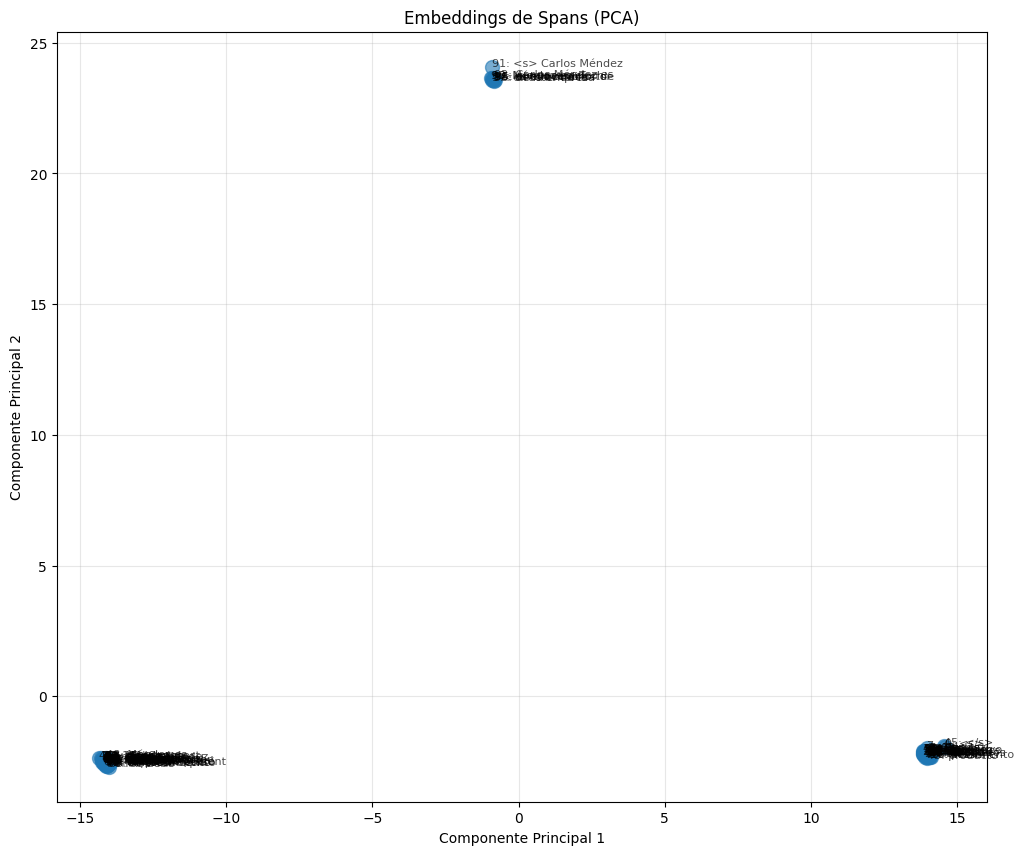

In [ ]:
## 🔍 CELDA DE EJECUCIÓN/INFERENCIA

def ejecutar_modelo_coref():
    """
    Función completa para cargar modelo y hacer predicciones
    """
    import os
    import torch
    from pathlib import Path

    print("="*80)
    print("🔍 EJECUCIÓN DE MODELO DE COREFERENCIA")
    print("="*80)

    # ============================================================================
    # CONFIGURACIÓN - ¡MODIFICA ESTOS VALORES!
    # ============================================================================

    # OPCIÓN A: Usar modelo recién entrenado (en memoria)
    USAR_MODELO_EN_MEMORIA = True  # True si acabas de entrenar, False para cargar de disco

    # OPCIÓN B: Cargar modelo desde disco (solo si USAR_MODELO_EN_MEMORIA = False)
    RUTA_MODELO_GUARDADO = "modelo_coref_entrenado"  # Carpeta donde está guardado

    # TEXTO A ANALIZAR
    TEXTO_A_ANALIZAR = """
    Carlos Méndez es el nuevo director de la empresa TechCorp.
    El ejecutivo presentó los resultados del trimestre.
    Méndez mostró un crecimiento del 15% en ventas.
    El director explicó que el éxito se debe al nuevo producto.
    """

    # PARÁMETROS DE INFERENCIA
    THRESHOLD = 0.3          # Umbral para considerar coreferencia (0.1-0.9)
    USAR_SLIDING_AUTO = True # True = decide automáticamente, False = siempre directo

    # ============================================================================
    # 1. CARGAR MODELO
    # ============================================================================

    model = None
    tokenizer = None

    print(f"\n📋 CONFIGURACIÓN:")
    print(f"   • Usar modelo en memoria: {'Sí' if USAR_MODELO_EN_MEMORIA else 'No'}")
    print(f"   • Ruta modelo: {RUTA_MODELO_GUARDADO if not USAR_MODELO_EN_MEMORIA else 'N/A'}")
    print(f"   • Threshold: {THRESHOLD}")
    print(f"   • Sliding automático: {'Sí' if USAR_SLIDING_AUTO else 'No'}")

    if USAR_MODELO_EN_MEMORIA:
        # Intentar usar modelo ya cargado en el notebook
        if 'model' in globals() and 'tokenizer' in globals():
            model = globals()['model']
            tokenizer = globals()['tokenizer']
            print(f"✅ Usando modelo ya cargado en memoria")
        else:
            print(f"⚠️  No hay modelo en memoria, cargando desde disco...")
            USAR_MODELO_EN_MEMORIA = False

    if not USAR_MODELO_EN_MEMORIA:
        # Cargar modelo desde disco
        if not os.path.exists(RUTA_MODELO_GUARDADO):
            print(f"\n❌ No se encuentra la carpeta del modelo: {RUTA_MODELO_GUARDADO}")
            print(f"📁 Directorio actual: {os.getcwd()}")
            print("\n📂 Carpetas disponibles:")
            carpetas = [d for d in os.listdir('.') if os.path.isdir(d)]
            for carpeta in carpetas:
                if os.path.exists(os.path.join(carpeta, "model.pt")):
                    print(f"   • {carpeta}/ (contiene model.pt)")

            # Preguntar por alternativa
            print(f"\n💡 Especifica otra ruta o:")
            print(f"   1. Entrena un modelo primero con la celda de entrenamiento")
            print(f"   2. Usa USAR_MODELO_EN_MEMORIA = True si ya entrenaste")
            return None

        print(f"\n📂 Cargando modelo desde: {RUTA_MODELO_GUARDADO}/")

        try:
            # Cargar checkpoint
            checkpoint_path = os.path.join(RUTA_MODELO_GUARDADO, "model.pt")
            checkpoint = torch.load(checkpoint_path, map_location=device)

            # Recrear modelo
            model = CoreferenceClusterModel(**checkpoint['model_config'])
            model.load_state_dict(checkpoint['model_state_dict'])
            model.to(device)
            model.eval()

            # Cargar tokenizer
            tokenizer = XLMRobertaTokenizer.from_pretrained(RUTA_MODELO_GUARDADO)

            print(f"✅ Modelo cargado exitosamente")
            if 'training_info' in checkpoint:
                info = checkpoint['training_info']
                print(f"   • Entrenado con: {info.get('conllu_file', 'desconocido')}")
                print(f"   • Épocas: {info.get('epochs', 'desconocido')}")
                print(f"   • Batch size: {info.get('batch_size', 'desconocido')}")

        except Exception as e:
            print(f"❌ Error al cargar modelo: {e}")
            return None

    if model is None or tokenizer is None:
        print("❌ No se pudo cargar el modelo")
        return None

    # ============================================================================
    # 2. ANALIZAR TEXTO
    # ============================================================================

    print(f"\n📝 Texto a analizar ({len(TEXTO_A_ANALIZAR.split())} palabras):")
    print("-" * 80)
    print(TEXTO_A_ANALIZAR[:500] + ("..." if len(TEXTO_A_ANALIZAR) > 500 else ""))
    print("-" * 80)

    # Decidir estrategia (directo vs sliding window)
    tokens = tokenizer.tokenize(TEXTO_A_ANALIZAR)
    num_tokens = len(tokens)

    usar_sliding = False
    if USAR_SLIDING_AUTO and num_tokens > 450:
        usar_sliding = True
        window_size = 400
        stride = 200
        print(f"\n🔧 Usando Sliding Window (texto largo: {num_tokens} tokens):")
        print(f"   • Window size: {window_size}")
        print(f"   • Stride: {stride}")
        print(f"   • Ventanas estimadas: {(num_tokens - window_size) // stride + 1}")
    else:
        print(f"\n🔧 Procesamiento directo ({num_tokens} tokens)")

    # Ejecutar predicción
    print(f"\n🧠 Procesando...")

    try:
        if usar_sliding:
            resultado = sliding_window_coref(
                texto_largo=TEXTO_A_ANALIZAR,
                modelo=model,
                tokenizer=tokenizer,
                window_size=window_size,
                stride=stride,
                threshold=THRESHOLD
            )
        else:
            resultado = predict_clusters(
                model=model,
                text=TEXTO_A_ANALIZAR,
                tokenizer=tokenizer,
                threshold=THRESHOLD,
                device=device
            )

        # ============================================================================
        # 3. MOSTRAR RESULTADOS
        # ============================================================================

        print(f"\n" + "="*80)
        print("📊 RESULTADOS DE LA ANÁLISIS")
        print("="*80)

        clusters = resultado.get('clusters', [])

        if clusters:
            print(f"\n✅ Se encontraron {len(clusters)} cluster(s) de coreferencia:")

            for i, cluster in enumerate(clusters):
                print(f"\n   CLUSTER {i+1} ({len(cluster)} menciones):")
                for j, mencion in enumerate(cluster):
                    texto_mencion = mencion['text'].replace('\n', ' ')
                    print(f"     {j+1}. \"{texto_mencion}\"")

            print(f"\n📈 Resumen:")
            total_menciones = sum(len(c) for c in clusters)
            print(f"   • Clusters totales: {len(clusters)}")
            print(f"   • Menciones totales: {total_menciones}")
            print(f"   • Promedio menciones por cluster: {total_menciones/len(clusters):.1f}")

            # Visualización
            print(f"\n👁️  ¿Quieres visualizar los clusters en el texto?")
            visualizar = input("   (s/n, Enter para Sí): ").strip().lower()
            if visualizar in ['s', 'si', 'sí', '']:
                print(f"\n📝 Visualización de clusters (primeros 1000 caracteres):")
                texto_visual = TEXTO_A_ANALIZAR[:1000] + ("..." if len(TEXTO_A_ANALIZAR) > 1000 else "")
                visualizar_clusters_sliding(texto_visual, resultado)
        else:
            print(f"\n⚠️  No se encontraron clusters de coreferencia en el texto.")
            print(f"   Esto puede significar:")
            print(f"   1. El texto no tiene referencias coreferenciales")
            print(f"   2. El threshold ({THRESHOLD}) es demasiado alto")
            print(f"   3. El modelo necesita más entrenamiento")

        # ============================================================================
        # 4. OPCIONES ADICIONALES
        # ============================================================================

        print(f"\n" + "-"*80)
        print("🔄 OPCIONES ADICIONALES")
        print("-"*80)

        print(f"1. 🔄 Probar con otro texto")
        print(f"2. 📊 Cambiar threshold (actual: {THRESHOLD})")
        print(f"3. 📈 Ver embeddings de spans (análisis avanzado)")
        print(f"4. 🚪 Salir")

        try:
            opcion = input("\nSelecciona opción (1-4, Enter para salir): ").strip()
        except:
            opcion = "4"

        if opcion == "1":
            nuevo_texto = input("\n📝 Escribe o pega el nuevo texto:\n").strip()
            if nuevo_texto:
                TEXTO_A_ANALIZAR = nuevo_texto
                print(f"\n🔄 Analizando nuevo texto...")
                # Podríamos hacer una llamada recursiva, pero por simplicidad:
                print(f"💡 Ejecuta de nuevo la función con el nuevo texto")

        elif opcion == "2":
            try:
                nuevo_threshold = float(input(f"\n📊 Nuevo threshold (0.1-0.9, actual {THRESHOLD}): ").strip())
                if 0.1 <= nuevo_threshold <= 0.9:
                    THRESHOLD = nuevo_threshold
                    print(f"✅ Threshold cambiado a {THRESHOLD}")
                    print(f"💡 Ejecuta de nuevo la función con el nuevo threshold")
                else:
                    print(f"❌ Threshold debe estar entre 0.1 y 0.9")
            except:
                print(f"❌ Valor inválido")

        elif opcion == "3":
            print(f"\n📈 Análisis de embeddings (primeros 500 caracteres):")
            texto_corto = TEXTO_A_ANALIZAR[:500]
            visualize_span_embeddings(texto_corto)

        return resultado

    except Exception as e:
        print(f"❌ Error durante el análisis: {e}")
        import traceback
        traceback.print_exc()
        return None


# ============================================================================
# FUNCIONES AUXILIARES (por si no están definidas)
# ============================================================================

def visualize_span_embeddings(text: str):
    """Visualiza embeddings de spans usando PCA"""
    try:
        from sklearn.decomposition import PCA
        import matplotlib.pyplot as plt

        if 'model' not in globals() or 'tokenizer' not in globals():
            print("❌ Modelo no está inicializado")
            return

        model.eval()
        with torch.no_grad():
            encoding = tokenizer(text, return_tensors="pt").to(device)
            outputs = model(encoding["input_ids"], encoding["attention_mask"], return_spans=True)

        if len(outputs['span_embeddings']) == 0 or len(outputs['span_embeddings'][0]) == 0:
            print("No se encontraron spans")
            return

        span_embeddings = outputs['span_embeddings'][0].cpu().numpy()
        span_indices = outputs['span_indices'][0]

        # Reducir dimensionalidad
        pca = PCA(n_components=2)
        embeddings_2d = pca.fit_transform(span_embeddings)

        # Obtener texto de cada span
        span_texts = []
        for start, end in span_indices:
            tokens = tokenizer.convert_ids_to_tokens(
                encoding["input_ids"][0][start:end+1]
            )
            span_text = tokenizer.convert_tokens_to_string(tokens)
            span_texts.append(span_text[:20])  # Limitar longitud

        # Visualizar
        plt.figure(figsize=(12, 10))
        plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, s=100)

        for i, (x, y) in enumerate(embeddings_2d):
            plt.annotate(f"{i}: {span_texts[i]}", (x, y), fontsize=8, alpha=0.7)

        plt.title("Embeddings de Spans (PCA)")
        plt.xlabel("Componente Principal 1")
        plt.ylabel("Componente Principal 2")
        plt.grid(True, alpha=0.3)
        plt.show()

    except ImportError:
        print("❌ Instala scikit-learn y matplotlib: !pip install scikit-learn matplotlib")
    except Exception as e:
        print(f"❌ Error en visualización: {e}")


# ============================================================================
# EJECUTAR INFERENCIA (descomenta la siguiente línea para ejecutar)
# ============================================================================

print("💡 Para ejecutar la inferencia, DESCOMENTA la siguiente línea:")
print("# resultado_analisis = ejecutar_modelo_coref()")

# Descomenta la siguiente línea para ejecutar:
resultado_analisis = ejecutar_modelo_coref()